# Forecasting organic growth

## Imports

In [35]:
import sys
import pandas as pd
import datetime as dt
import numpy as np
import time

from pytrends.request import TrendReq as UTrendReq
import requests

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('whitegrid')

from prophet import Prophet
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from tqdm.notebook import tqdm
from IPython.display import display, HTML

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Preprocessing 

In [13]:
country = "CAN"
brands_name = {"BELGIUM": ["APERICUBE", "BABYBEL", "BOURSIN", "KIRI", "MINI BABYBEL", "VACHE QUI RIT", "MAREDSOUS"],
     "USA": ["BABYBEL", "THE LAUGHING COW", "BOURSIN", "KAUKAUNA", "MERKTS", "PRICES", "NURISHH"],
     "FR": ['APERICUBE', 'BABYBEL', 'BOURSIN', 'COUSTERON', 'KIRI', 'LA VACHE QUI RIT', 'PORT SALUT', 'NURISHH'],
     "CAN": ['BOURSIN', 'KIRI', 'LA VACHE QUI RIT', 'MINI BABYBEL', 'NURISHH']}
aandp_brands_name = {"BELGIUM": ["APERICUBE", "BABYBEL", "BOURSIN", "KIRI", "MINI BABYBEL", "VACHE QUI RIT", "MAREDSOUS"],
    "USA": ["000BQ - BOURSIN", "000LA - THE LAUGHING COW", "000MB - MINI BABYBEL", "000KC - KAUKAUNA", "000PG - PRICE'S", "000MI - MERKTS", "003NH - NURISHH"]}

features = ["Date", "Brand", "Category", "Distribution", "Price per volume", "Sales in volume"]

In [203]:
df = pd.read_excel('data/CAN/df.xlsx')
df = df.fillna(0)

In [194]:
df_bel = pd.read_excel('data/CAN/df_bel.xlsx')

In [216]:
df_bel.dtypes

Date                   object
Brand                  object
Price per volume      float64
Sales in volume       float64
Sales in value          int64
Distribution          float64
A&P                   float64
Rate of Innovation    float64
Promo Cost            float64
dtype: object

In [214]:
df[['Price per volume', 'Price with promo']] = df.replace("ERR", 0)[['Price per volume', 'Price with promo']].applymap(float)

In [212]:
len(df[df['Price with promo'] == "ERR"])

108

In [205]:
df['Price per volume'] = df['Price per volume'].apply(float)

ValueError: could not convert string to float: 'ERR'

In [209]:
df['Price per volume'].str.findall(r'[a-zA-Z]+')

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
169099    NaN
169100    NaN
169101    NaN
169102    NaN
169103    NaN
Name: Price per volume, Length: 169104, dtype: object

In [186]:
df_bel.Date.sort_values()[0]

'2019-01-12'

In [43]:
df.head()
df_bel.head()

Product Category Sub Category        Brand  \
0  A FB BRND BLCK BL A BLCK LCT FR/LGHT    BLOCK  BL AO BLOCK  AO FB BRAND   
1  A FB BRND BLCK BL A BLCK LCT FR/LGHT    BLOCK  BL AO BLOCK  AO FB BRAND   
2  A FB BRND BLCK BL A BLCK LCT FR/LGHT    BLOCK  BL AO BLOCK  AO FB BRAND   
3  A FB BRND BLCK BL A BLCK LCT FR/LGHT    BLOCK  BL AO BLOCK  AO FB BRAND   
4  A FB BRND BLCK BL A BLCK LCT FR/LGHT    BLOCK  BL AO BLOCK  AO FB BRAND   

         Channel        Date  Sales in value  Sales value with promo  \
0  Total Country  2019-01-12             NaN                     NaN   
1  Total Country  2019-01-19             NaN                     NaN   
2  Total Country  2019-01-26             NaN                     NaN   
3  Total Country  2019-02-02             NaN                     NaN   
4  Total Country  2019-02-09             NaN                     NaN   

   Sales in volume Sales volume with promo  Distribution  Price per volume  \
0              NaN                     NaN           NaN               NaN   
1              NaN                     NaN           NaN               NaN   
2              NaN                     NaN           NaN               NaN   
3              NaN                     NaN           NaN               NaN   
4              NaN                     NaN           NaN               NaN   

  Price with promo  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

Date             Brand  Price per volume  Sales in volume  \
0  2019-01-12           BOURSIN       3153.150000              477   
1  2019-01-12              KIRI          4.100000               25   
2  2019-01-12  LA VACHE QUI RIT       6282.500000              748   
3  2019-01-12      MINI BABYBEL       4692.633333              589   
4  2019-01-12           NURISHH          0.000000                0   

   Sales in value   Distribution            A&P  Rate of Innovation  \
0          493926  111037.500000   48910.862475                 0.0   
1           17202     125.000000    4308.950000                 0.0   
2          733335  136112.000000  160014.455025                 0.0   
3          888460  149572.333333  229418.949975                 0.0   
4               0       0.000000       0.000000                 0.0   

   Promo Cost  
0         0.0  
1         0.0  
2         0.0  
3      3716.4  
4         0.0

In [44]:
df.describe()
df_bel.describe()

Sales in value  Sales value with promo  Sales in volume  Distribution  \
count    1.300630e+05           130063.000000    130063.000000  8.974100e+04   
mean     7.099760e+04             4156.526389        39.742632  5.254389e+04   
std      2.979818e+05            21656.364136       105.660106  2.144241e+05   
min      0.000000e+00                0.000000         0.000000  2.000000e+00   
25%      8.250000e+02               25.700000         1.000000  6.320000e+02   
50%      6.437000e+03              201.300000         9.000000  4.067000e+03   
75%      3.498600e+04             1358.000000        35.000000  2.208200e+04   
max      8.443774e+06           786108.300000      1444.000000  5.860155e+06   

       Price per volume  
count      89741.000000  
mean        3640.498817  
std        17720.850194  
min            0.000000  
25%           22.900000  
50%          150.200000  
75%          976.200000  
max       595182.100000

Price per volume  Sales in volume  Sales in value  Distribution  \
count        780.000000       780.000000    7.800000e+02  7.800000e+02   
mean        2742.865798       434.676923    5.488923e+05  8.040902e+04   
std         3569.492128       346.858594    4.869051e+05  1.152048e+05   
min            0.000000         0.000000    0.000000e+00  0.000000e+00   
25%          197.175000        37.750000    2.498500e+04  4.786750e+03   
50%         2212.363333       602.500000    6.856280e+05  5.531024e+04   
75%         3848.866667       734.250000    9.060878e+05  1.057761e+05   
max        44809.550000       907.000000    3.332339e+06  1.419708e+06   

                 A&P  Rate of Innovation    Promo Cost  
count     780.000000          780.000000    780.000000  
mean    53302.737370            0.048916   2188.356421  
std     71152.626764            0.165106   4305.248404  
min         0.000000            0.000000      0.000000  
25%         0.000000            0.000000      0.000000  
50%     28285.834975            0.000000      0.000000  
75%     73686.780075            0.000000   2720.862990  
max    333803.314975            1.000000  32140.262140

Dictionary of brand's markets.

In [12]:
df_bel.Brand.unique()

array(['BOURSIN', 'KIRI', 'LA VACHE QUI RIT', 'MINI BABYBEL', 'NURISHH'],
      dtype=object)

In [45]:
brands_markets = {brand: df[df.Brand == brand].Category.unique().tolist() for brand in brands_name[country]}
bel_markets = list(set([elem for brand in brands_markets for elem in brands_markets[brand]]))
brands_markets
bel_markets

{'BOURSIN': ['PLATTER', 'SPECIALTY', 'SNACKING', 'PLANT BASED'],
 'KIRI': ['SNACKING', 'SPREADABLE'],
 'LA VACHE QUI RIT': ['SNACKING'],
 'MINI BABYBEL': ['SNACKING'],
 'NURISHH': ['PLANT BASED']}

['SPREADABLE', 'SNACKING', 'PLATTER', 'PLANT BASED', 'SPECIALTY']

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

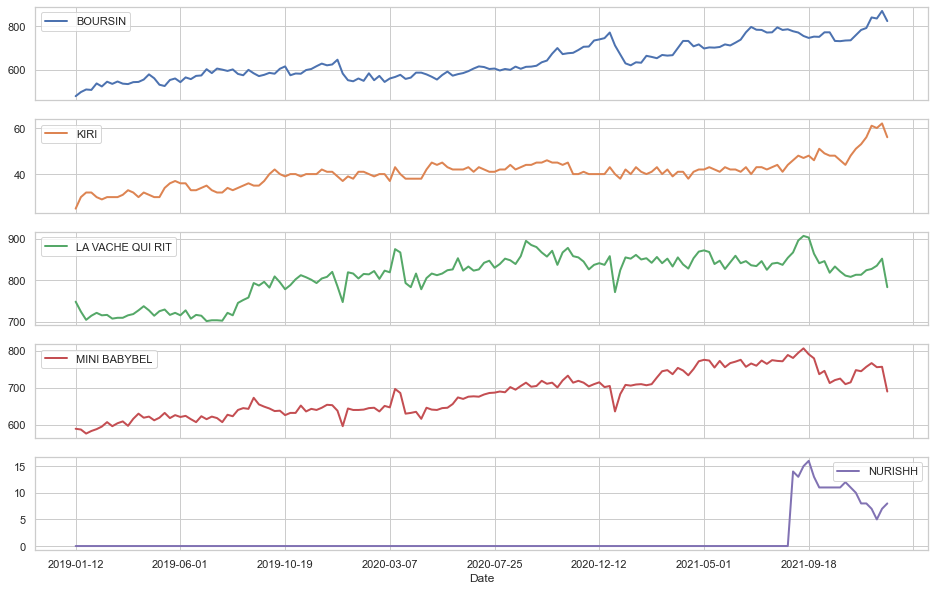

In [47]:
df_bel.reset_index().groupby(['Date', 'Brand']).agg('sum').unstack()['Sales in volume'].plot(subplots=True, linewidth=2, figsize=(16, 10))

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

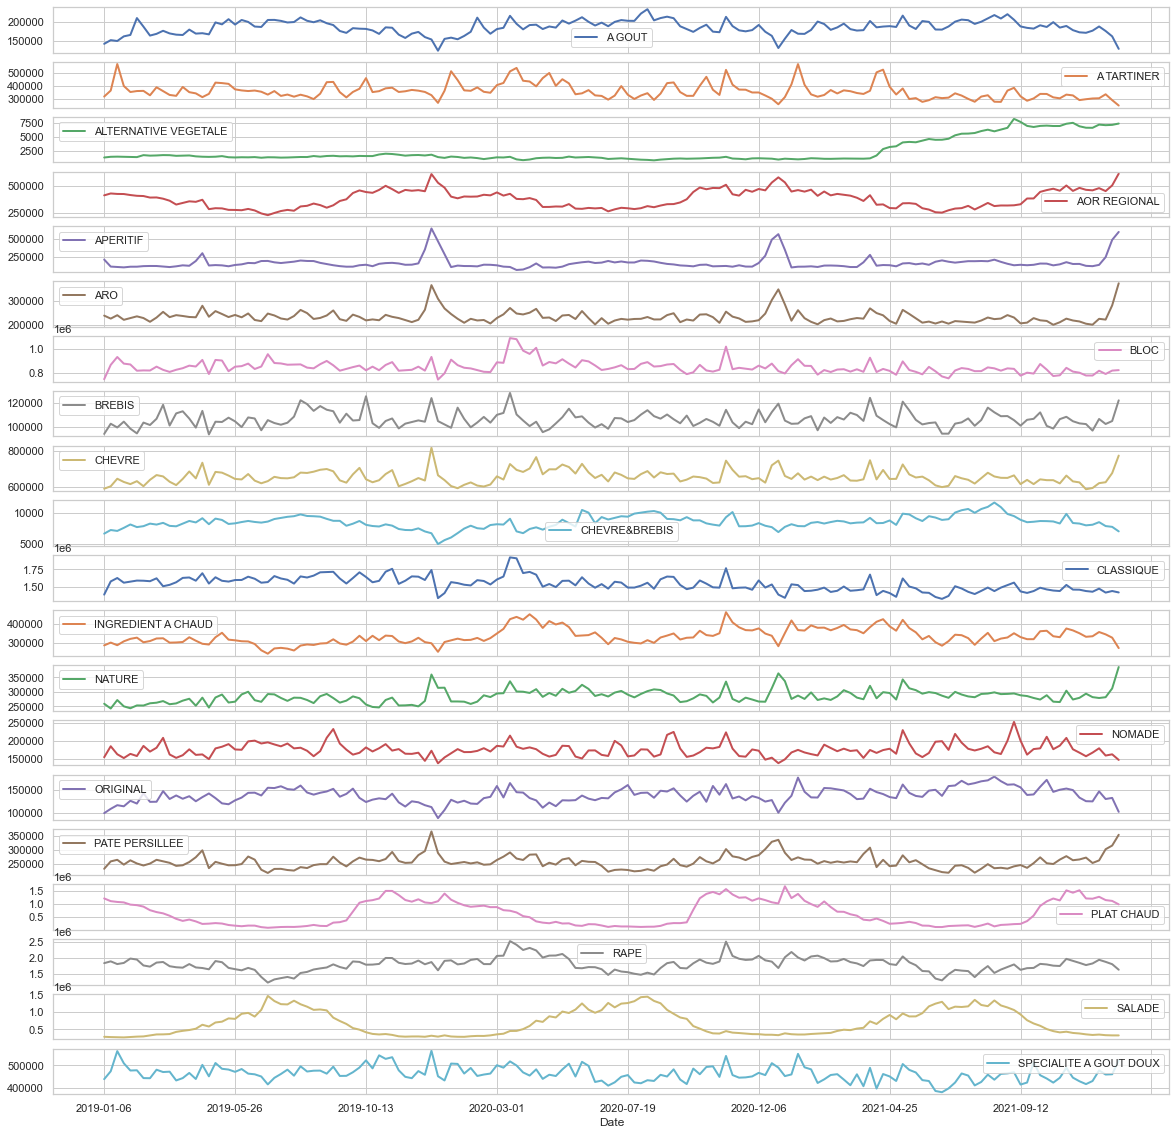

In [10]:
df_hmsm.reset_index().groupby(['Date', 'Category']).agg('sum').unstack()['Sales in volume'].plot(subplots=True, linewidth=2, figsize=(20, 20))

In [50]:
def get_df_brands(data_manager, country, brands_name, features):
    """Get the right DataFrame giving the country, the brands and features 
    from the datamanager
    """
    df_res = df[df.Brand.isin(
        brands_name[country])][features]
    df_res = df_res.fillna(0)

    return df_res

def get_df_competition_brands(df, brands_name, features):
    """Get the dataframe of all the other brands except the given ones with 
    the specified features
    """
    df_res = df[~(df.Brand.isin(
        brands_name)) & (df.Category.isin(
        bel_markets))][features]
    df_res = df_res.fillna(0)
    
    return df_res

def get_df_markets(df):
    """Get Markets dataframe
    """
    df_res = df.groupby(['Category', 'Date']).agg("sum")[
        ['Sales in volume']].unstack(0)
    df_res = df_res.droplevel(level=0, axis=1).reset_index()
    df_res['TOTAL CHEESE'] = df_res.iloc[:, 1:].sum(axis=1)
    df_res = df_res.fillna(0)
    df_res.columns.name = ''

    return df_res


def forecasting_features(df, features, periods=36, freq='MS'):
    """Get long term forecasts for features giving the dataframe and periods
    """
    # Select features except the target
    list_df_features = []
    for feature in tqdm(features, ascii=True, desc='Features'):
        model = Prophet()
        # Preprocessing Inputs of Prophet
        df_frcast = df[['Date', feature]]
        df_frcast.columns = ['ds', 'y']
        df_frcast.ds = pd.to_datetime(df_frcast.ds)
        df_frcast['cap'] = df[feature].max() * 3
        df_frcast['floor'] = df[feature].mean() / 2
        
        if (df_frcast['cap'] <= df_frcast['floor']).any():
            df_frcast['cap'] = df_frcast.floor + 1
        
        # Model
        model = Prophet(growth='logistic', yearly_seasonality=20)
        model.fit(df_frcast)

        # Periods is in months
        future = model.make_future_dataframe(periods=periods, freq=freq)
        future['cap'] = df_frcast['cap'][0]
        future['floor'] = df_frcast['floor'][0]
        fcst = model.predict(future[future.ds > df_frcast.ds.iloc[-1]])
        
        # Plot forecast
        fig = model.plot(fcst)
        ax = fig.gca()
        ax.set_title(feature)
        
        df_frcast.rename(columns={'y': feature}, inplace=True)
        fcst.rename(columns={'yhat': feature}, inplace=True)
        # Adding result to list
        list_df_features.append(pd.concat([df_frcast.iloc[:, :-2], fcst[['ds', feature]]]))

    # Merging the dataframes of each feature
    df_features = list_df_features[0][['ds']]
    for dff in list_df_features:
        df_features = pd.merge(df_features, dff, on='ds')

    df_features.rename(columns={'ds': 'Date'}, inplace=True)
    return df_features

def forecasting_features_brand(df, features, periods=36, freq='MS'):
    """Get long term forecasts for features giving the dataframe and periods
    """
    # Select features except the target
    list_df_features = []
    for feature in tqdm(features, ascii=True, desc='Features'):
        model = Prophet()
        # Preprocessing Inputs of Prophet
        df_frcast = df[['Date', feature]]
        df_frcast.columns = ['ds', 'y']
        df_frcast.ds = pd.to_datetime(df_frcast.ds)
        
        # Model
        model = Prophet()
        model.fit(df_frcast)

        # Periods is in months
        future = model.make_future_dataframe(periods=periods, freq=freq)
        fcst = model.predict(future[future.ds > df_frcast.ds.iloc[-1]])
        
        # Plot forecast
        fig = model.plot(fcst)
        ax = fig.gca()
        ax.set_title(feature)
        
        df_frcast.rename(columns={'y': feature}, inplace=True)
        fcst.rename(columns={'yhat': feature}, inplace=True)
        # Adding result to list
        list_df_features.append(pd.concat([df_frcast, fcst[['ds', feature]]]))

    # Merging the dataframes of each feature
    df_features = list_df_features[0][['ds']]
    for dff in list_df_features:
        df_features = pd.merge(df_features, dff, on='ds')

    df_features.rename(columns={'ds': 'Date'}, inplace=True)
    return df_features


def forecasting_one_brand(df, brand_name, features_name, periods=36, freq='MS'):
    """ Forecasting giving brand_name for giving number of periods and 
    features to use. 
    """
    # Get DataFrame for brand_name
    df = df.groupby(["Brand", "Date"]).agg(
        "sum").loc[brand_name].reset_index().sort_values('Date')
    
    # Predict long-term forecast for features
    df_features = forecasting_features_brand(df, features_name, periods=periods, freq=freq)
    # Preprocessing dataframe for prophet
    df['Date'] = pd.to_datetime(df.Date)
    #df = pd.merge(df_features_train, df[['Date', 'Sales in volume']], on='Date', how='inner')
    df = df[['Date', *features_name, 'Sales in volume']]
    df.rename(columns={'Date': 'ds', 'Sales in volume': 'y'}, inplace=True)
    
    df['cap'] = df['y'].max() * 3
    df['floor'] = df['y'].min() / 2
    if (df['cap'] <= df['floor']).any():
        df['cap'] = df.floor + 1

    
    # Instanciating Prophet Model
    model = Prophet(growth='logistic', yearly_seasonality=20)
    # Adding regressors
    for feature in features_name:
        model.add_regressor(feature)

    # Fitting model
    model.fit(df)
    
    future = model.make_future_dataframe(periods=periods, freq=freq)

    for feature in features_name:
        future[feature] = df_features[feature]
    

    future['cap'] = df['cap'][0]
    future['floor'] = df['floor'][0]
    
    # Predicting sales forecasts
    fcst = model.predict(future[future.ds > df.ds.iloc[-1]])
    
    # Plot forecast
    fig = model.plot(fcst)
    ax = fig.gca()
    ax.set_title(brand_name)
    
    fcst.rename(columns={'yhat':'y'}, inplace=True)
    df_brand_fcst = pd.concat([df[['ds', 'y']], fcst[['ds', 'y']]])
    df_brand_fcst.rename(columns={'ds': 'Date', 'y': brand_name}, inplace=True)

    return future, df_brand_fcst


def forecasting_brands(df, brands_name, features_name, periods=36, freq='MS'):
    """Forecasting a list of brands using the given features and periods
    """
    
    dict_feats_futures = {}
    list_df_brands = []
    # Compute forecast for each brand
    for brand in tqdm(brands_name, ascii=True, desc='Brands'):
        future, brand_fcst = forecasting_one_brand(df, brand, features_name, periods=periods, freq=freq)
        dict_feats_futures[brand] = future
        list_df_brands.append(brand_fcst)

    # Merge results of each brand
    df_brands_fcst = list_df_brands[0].Date
    for df_tmp in list_df_brands:
        df_brands_fcst = pd.merge(df_brands_fcst, df_tmp, on='Date', how='outer')

    return dict_feats_futures, df_brands_fcst


def forecasting_markets(df, markets_name, periods=36, freq='MS'):
    """Forecasting list of markets for the given periods
    """
    df_features = forecasting_features(df, markets_name, periods=periods, freq=freq)

    return df_features

def mitigate_covid(df, features, dates):
    """
    """
    pass
    
# Get adjusted features for organic growth
def adjust_organic_growth_features(df_features):
    """Adjust organic growth features for computing correlation of growth
    Drivers in the future (forecast)
    """
    df_organicforecast_feature = df_features.copy()
    feature_columns = list(df_organicforecast_feature)[1:]
    controlable_features = feature_columns[:4]
    df_organic_forecast_feature["Distribution"] = 0
    df_organic_forecast_feature["Rate of innovation"] = 0
    price_75percentile = df_organic_forecast_feature["Price per volume"].quantile(
        0.75)
    df_organic_forecast_feature["Price per volume"] = df_organic_forecast_feature["Price per volume"].apply(
        lambda x: x*1.25 if x <= price_75percentile else x)
    TDP_75percentile = df_organic_forecast_feature["TDP"].quantile(0.75)
    df_organic_forecast_feature["TDP"] = df_organic_forecast_feature["TDP"].apply(
        lambda x: x*0.75 if x >= TDP_75percentile else x)
    
    return df_organic_forecast_feature

### Computing Trends

In [187]:
kw_list = brands_name[country]
timeframes = list(df_bel.Date.unique())
tdelta_day = dt.timedelta(days=1)
tdelta_week = dt.timedelta(weeks=1)
timeframes.insert(0, (dt.datetime.strptime(timeframes[0], '%Y-%m-%d') - tdelta_week).strftime('%Y-%m-%d'))
timeframes.append((dt.datetime.strptime(timeframes[-1], '%Y-%m-%d') + tdelta_week).strftime('%Y-%m-%d'))
    
geo='CA'
GET_METHOD='get'
headers = {
'authority': 'trends.google.com',
'cache-control': 'max-age=0',
'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="98", "Google Chrome";v="98"',
'sec-ch-ua-mobile': '?0',
'sec-ch-ua-platform': '"macOS"',
'upgrade-insecure-requests': '1',
'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36',
'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
'x-client-data': 'CJ7fygE=',
'sec-fetch-site': 'same-origin',
'sec-fetch-mode': 'navigate',
'sec-fetch-user': '?1',
'sec-fetch-dest': 'document',
'referer': 'https://trends.google.com/trends/?geo='+geo,
'accept-language': 'fr-FR,fr;q=0.9,en-US;q=0.8,en;q=0.7',
'cookie': '__utma=10102256.2142090120.1645455402.1645455402.1645455402.1; __utmc=10102256; __utmz=10102256.1645455402.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); __utmt=1; __utmb=10102256.5.9.1645455408893; CONSENT=YES+srp.gws-20220217-0-RC1.fr+FX+004; 1P_JAR=2022-02-21-15; SID=HQgzK1_QHq5O4Gxfol7wNIQ8JBvuh_XBbe-63vwnERFhFJEa8TFYSMqHR-5OUrj7OtQx_A.; __Secure-1PSID=HQgzK1_QHq5O4Gxfol7wNIQ8JBvuh_XBbe-63vwnERFhFJEawJmkuoBDtYla3S3m5hx8kQ.; __Secure-3PSID=HQgzK1_QHq5O4Gxfol7wNIQ8JBvuh_XBbe-63vwnERFhFJEaG7QfexXpqx5lg43EMUQUQw.; HSID=A_K65lvXgt3Scuc0n; SSID=Ajaw0EKPT7Ok638qm; APISID=1gdUaeoAbGY0hQBG/A68-B5BtWRxthyMoo; SAPISID=35kLI8C4oe7oZA-1/Ao42EJJT31v8K2hBe; __Secure-1PAPISID=35kLI8C4oe7oZA-1/Ao42EJJT31v8K2hBe; __Secure-3PAPISID=35kLI8C4oe7oZA-1/Ao42EJJT31v8K2hBe; NID=511=odIcinna2wJGUmMhN_uM0o_utTxPmkP7IP3WPOfwUDcgDxNaSaK0g-JdjZ15JWlWHpgSqsD2-DFJcy4-F8KfN5oGoz3dsqRKBpr0cgLmyefwq5Dsd2fLlSUh9HJhga7TaUfRKSdu09XitvJ8nCdnGN4iDLenCzdI5qEfyHyB3wJAZyONpYd-P1JtXD56OKnm-wJ5JoJObdm67M_myZj4PiOjMvOeVvnAMVHnZee48Ho; SIDCC=AJi4QfF7GP5rUgjZhMuSVECtziYI-TgFSUpdgGLTnDwYSuP22BrKzLUpdkcYO4aLQjG4jg09; __Secure-3PSIDCC=AJi4QfGKL18okfSNCPOhtb0IHAOOHOOROq_xm0P_hN0fwHW0il9jxtNj4ChDoxtjdexO_l6d',
}

class TrendReq(UTrendReq):
    def _get_data(self, url, method=GET_METHOD, trim_chars=0, **kwargs):
        return super()._get_data(url, method=GET_METHOD, trim_chars=trim_chars, headers=headers, **kwargs)

def compute_trends(geo, kw_list, timeframes):
    """
    """
    pytrend = TrendReq(hl=geo, tz=360)
    dataset = []
    for i in tqdm(range(1, len(timeframes)), desc='TimeFrames', ascii=True):
        # Merge kw queries results, only 5 max can be queried in an iteration
        tmp_data_raw = [timeframes[i]]
        for j in range(0, len(kw_list), 5):
            # 5: because only 5 keywords can be computed at the same time
            pytrend.build_payload(
                kw_list=kw_list[j:j+5],
                timeframe='{} {}'.format(timeframes[i-1], timeframes[i]), 
                geo=geo,
                gprop='')
            data = pytrend.interest_over_time().sum(axis=0)
            # [:-1] in order to not take into account the isPartial column 
            tmp_data_raw += list(data.values)[:-1]
        dataset.append(tmp_data_raw)

    df_trends = pd.DataFrame(dataset, columns=['Date'] + kw_list)
    return df_trends

def compute_trends_bis(geo, kw_list, start_date, end_date):
    """
    """
    pytrend = TrendReq(hl=geo, tz=360)
    dataset = pd.DataFrame()
    for i in range(0, len(kw_list), 5):
        pytrend.build_payload(
            kw_list=kw_list[i:i+5],
            timeframe='{} {}'.format(start_date, end_date),
            geo=geo,
            gprop='',
            cat=71
        )
        data = pytrend.interest_over_time()
        dataset = pd.concat([dataset, data.iloc[:, :-1]], axis=1)
        
    return dataset

In [188]:
df_trends = compute_trends_bis('CA', kw_list, start_date=timeframes[0], end_date=timeframes[-1])
df_trends = df_trends.reset_index().rename(columns={'date':'Date'})
df_trends.head()

ConnectTimeout: HTTPSConnectionPool(host='trends.google.com', port=443): Max retries exceeded with url: /?geo=CA (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7fb68e801ed0>, 'Connection to trends.google.com timed out. (connect timeout=2)'))

In [122]:
df_trends['Date'] = df_trends.Date.apply(lambda x: x - tdelta_day)

In [123]:
df_trends.tail()

Date  BOURSIN  KIRI  LA VACHE QUI RIT  MINI BABYBEL  NURISHH
152 2021-12-04       67     5                 2             2        0
153 2021-12-11       65    11                 3             0        0
154 2021-12-18       91     6                 2             0        0
155 2021-12-25      100    15                 5             2        0
156 2022-01-01       65     3                 1             1        0

In [ ]:
df_trends.to_csv('../data/brand_trends_usa.csv')

### Forecasting Brands

#### No regressors

Features:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -2.58293
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.164    0.00912676       186.759           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       428.429   0.000892239       63.4235   1.064e-05       0.001      268  LS failed, Hessian reset 
     199       428.891    0.00341281       69.7123           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       429.196   7.24251e-06       66.6368      0.1729      0.1729      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       429.259     0.0007786       87.8177   1.218e-05       0.001      505  LS failed, Hessian reset 
     388       429.306   1.90869e-06       77.3943   2.313e-08       0.001      620  LS failed, Hessian rese

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -4.29623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        341.15    0.00155974       66.4558      0.8524      0.8524      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        342.66   0.000113852        63.458      0.1785           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       342.701   0.000458451       58.3421           1           1      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       342.718   2.14677e-06       85.6352           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       342.803   8.57577e-06       51.5932           1           1      628   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -7.85764
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.014     0.0155731       568.206      0.4741           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       418.479   1.00276e-05       56.6943   6.264e-08       0.001      257  LS failed, Hessian reset 
     199       418.917   0.000840535       302.472           1           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       420.498   0.000379125        66.389     0.04135           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       420.574   1.91222e-05       35.9559    6.05e-08       0.001      546  LS failed, Hessian reset 
     361       420.585   4.14282e-06       43.1559   7.107e-08       0.001      641  LS failed, Hessian rese

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -3.67807
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.988    0.00617804       145.809      0.4081      0.8258      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       442.871    0.00203426       197.983   2.084e-05       0.001      238  LS failed, Hessian reset 
     197       443.977    0.00022845        139.22   2.509e-06       0.001      341  LS failed, Hessian reset 
     199       444.014   9.31804e-05       43.1418           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       444.988    0.00129105       91.4631           1           1      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     358       445.253   3.42588e-05       67.2432   5.119e-07       0.001      595  LS failed, Hessian rese

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -5.90511
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       195.834   1.63214e-05       94.2928           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       195.836   3.42226e-09       68.1703      0.3589      0.3589      222   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


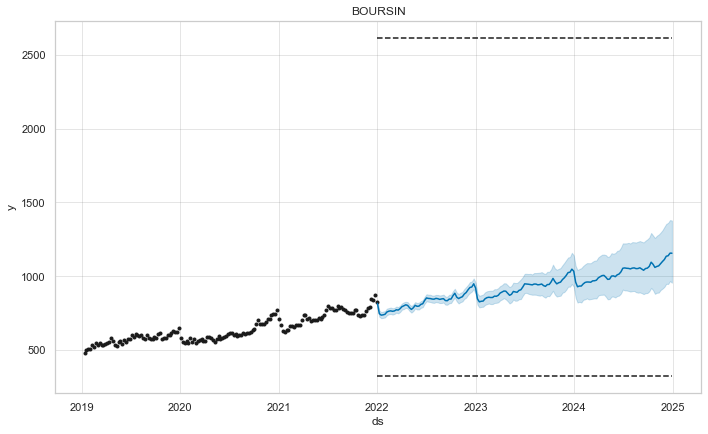

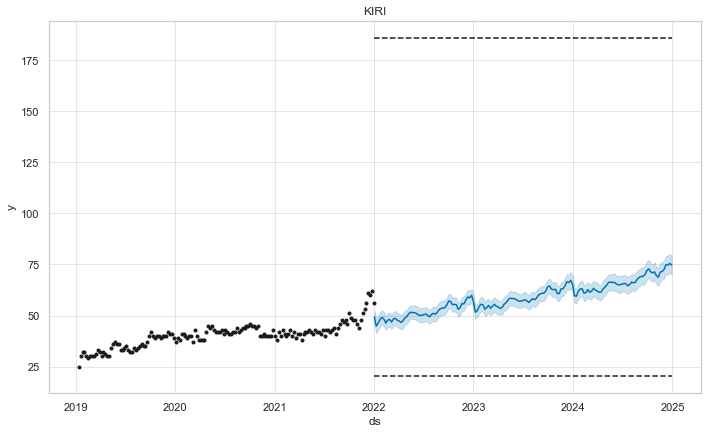

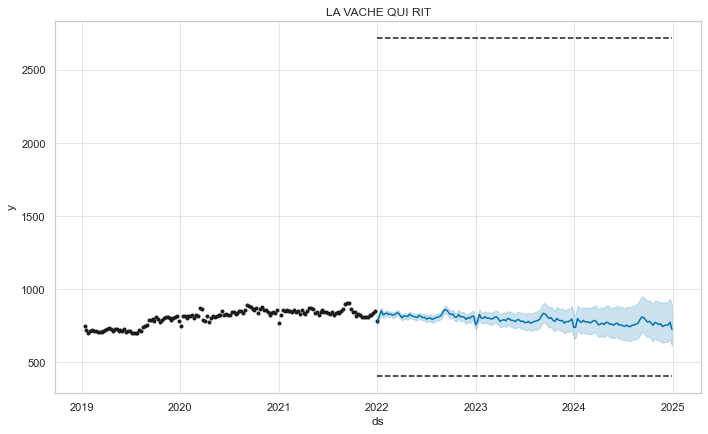

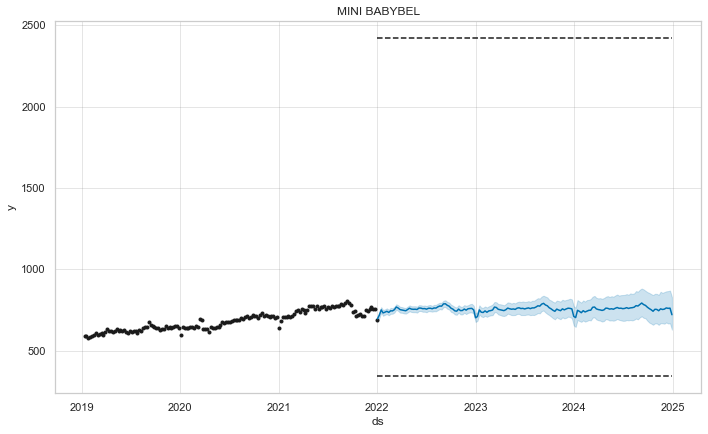

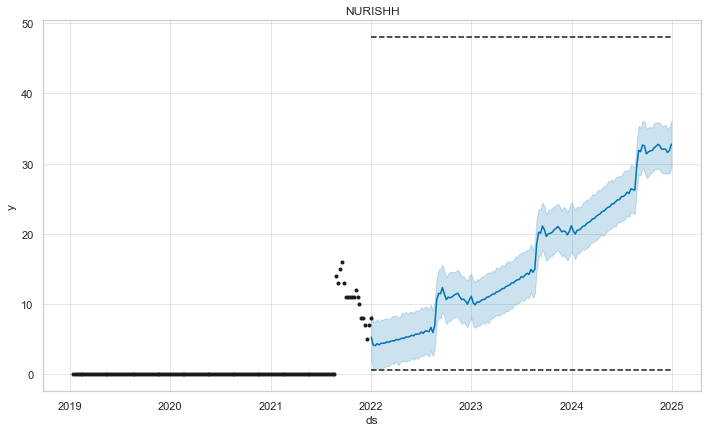

In [70]:
df_bel_brands = df_bel.groupby(["Date", "Brand"]).agg('sum')['Sales in volume'].unstack().reset_index()
df_bel_brands.columns.name=''
df_bel_brands = df_bel_brands.fillna(0)
df_bel_brands_fcst_res = forecasting_features(df_bel_brands, list(df_bel_brands.columns[1:]), periods=157, freq='W')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

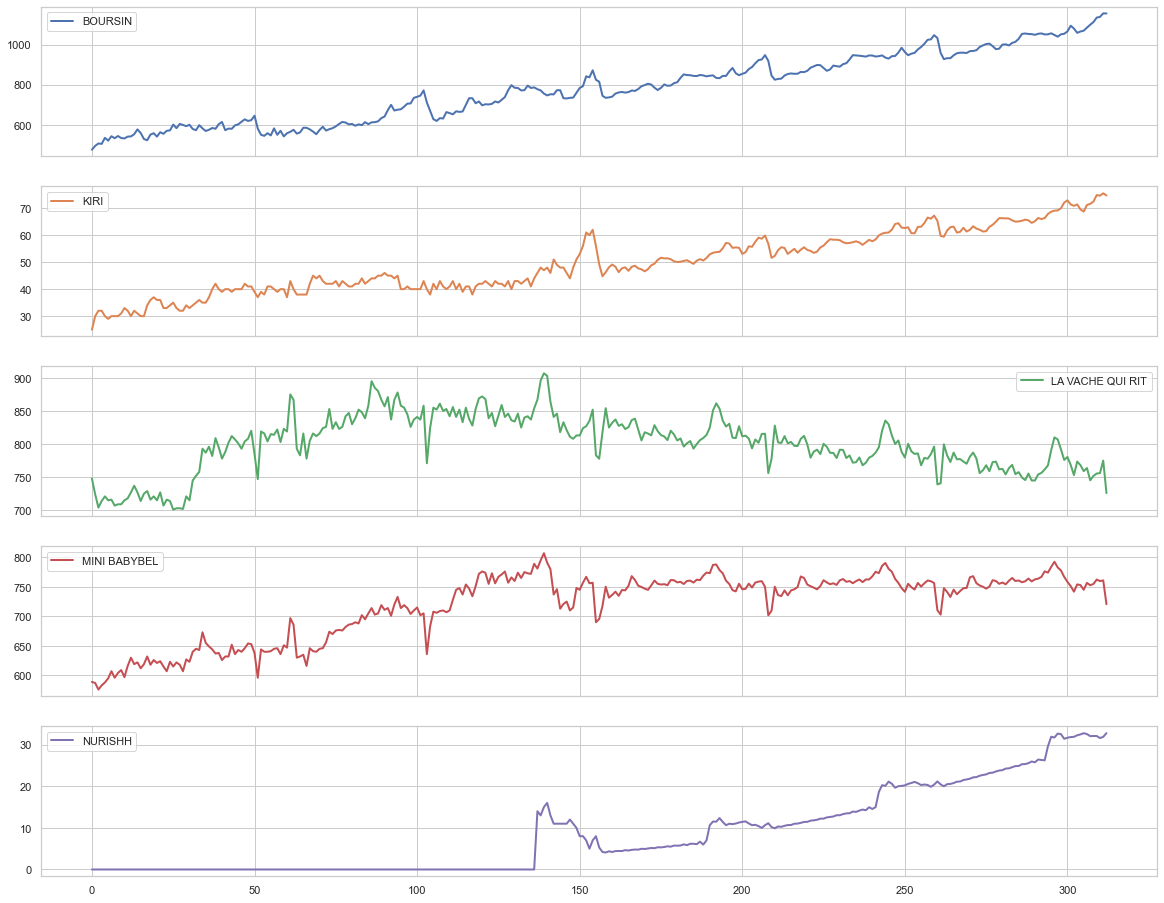

In [71]:
df_bel_brands_fcst_res.iloc[:, 1:].plot(subplots=True, linewidth=2, figsize=(20, 16))

In [72]:
df_bel_brands_fcst_res['Date'] = df_bel_brands_fcst_res.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
df_bel_brands_fcst_res.round(1).to_excel("results/CAN/can_brands_forecasts_no_regressors.xlsx", index=False)

#### With Regressors

In [125]:
df_bel = df_bel.fillna(0)
df_bel['Trends'] = df_bel.apply(lambda x: df_trends[df_trends.Date == x.Date][x.Brand].values[0], axis=1)
df_bel.fillna(0, inplace=True)
df_bel.head()

Date             Brand  Price per volume  Sales in volume  \
0  2019-01-12           BOURSIN       3153.150000              477   
1  2019-01-12              KIRI          4.100000               25   
2  2019-01-12  LA VACHE QUI RIT       6282.500000              748   
3  2019-01-12      MINI BABYBEL       4692.633333              589   
4  2019-01-12           NURISHH          0.000000                0   

   Sales in value   Distribution            A&P  Rate of Innovation  \
0          493926  111037.500000   48910.862475                 0.0   
1           17202     125.000000    4308.950000                 0.0   
2          733335  136112.000000  160014.455025                 0.0   
3          888460  149572.333333  229418.949975                 0.0   
4               0       0.000000       0.000000                 0.0   

   Promo Cost  Trends  
0         0.0      39  
1         0.0       2  
2         0.0       0  
3      3716.4       0  
4         0.0       0

Brands:   0%|          | 0/5 [00:00<?, ?it/s]

Features:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.2331
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       195.774    6.8065e-06        90.577   7.165e-08       0.001      159  LS failed, Hessian reset 
      99       195.775   2.93683e-06       71.1963           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       195.775   8.43636e-09       76.6695      0.5842      0.5842      229   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.49209
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       328.119   0.000697392       83.4045   7.131e-06       0.001      153  LS failed, Hessian reset 
      99       328.145   0.000107694       81.6113      0.8548      0.8548      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       328.152   9.74871e-09       76.3247      0.7267      0.7267      209   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.67294
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       327.366   0.000248581       90.8228      0.3228           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       327.661   1.57331e-08       76.6547      0.2682           1      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.22299
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      35       265.283   0.000226465       44.8713   3.289e-06       0.001       89  LS failed, Hessian reset 
      73       265.298   9.00441e-05       61.2632   1.346e-06       0.001      180  LS failed, Hessian reset 
      99       265.301   2.06532e-06       60.7057     0.08513     0.08513      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       265.303   1.42085e-05        49.273   2.662e-07       0.001      273  LS failed, Hessian reset 
     150       265.384   0.000580867       57.6936   9.705e-06       0.001      379  LS failed, Hessian reset 
     185       265.415   8.35538e-06       78.0912   1.507e-07       0.001      473  LS failed, Hessian reset 
     199       265.415   4.91596e-07       61.8693     0.09875      0.6367      492   
    Iter      log prob        ||dx||      ||gr

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.97143
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.106   2.31017e-07       80.3915      0.2607           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       217.106   9.79532e-09       77.1829      0.2197      0.2197      151   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.43895
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       462.071    0.00372615       86.6755           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       462.512    0.00034263       79.3462   4.341e-06       0.001      169  LS failed, Hessian reset 
     166       464.028   0.000669735       97.3851   4.927e-06       0.001      268  LS failed, Hessian reset 
     199       464.709   0.000107483       65.2042       0.509       0.509      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       464.956   0.000982742       92.0024    1.35e-05       0.001      396  LS failed, Hessian reset 
     299       465.175   0.000621659       64.3276      0.5415      0.5415      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Features:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.16706
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       248.817   0.000717426       64.4316   1.102e-05       0.001      131  LS failed, Hessian reset 
      99       248.876   0.000104593       50.6727      0.4547      0.4547      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       248.879   1.26109e-05       62.5803   1.593e-07       0.001      243  LS failed, Hessian reset 
     199       248.959    0.00343015       51.2318           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201        248.98    0.00118646       58.8843   2.689e-05       0.001      393  LS failed, Hessian reset 
     226       249.054   5.68053e-05       49.6844   9.515e-07       0.001      465  LS failed, Hessian reset 
     266       249.056   3.43477e-07       56.6431   6.603e-09   

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.78635
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       222.498   0.000148617       81.6872           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       222.542   0.000153508       74.9678   1.718e-06       0.001      256  LS failed, Hessian reset 
     194        222.55   2.89899e-06       58.5384    3.96e-08       0.001      332  LS failed, Hessian reset 
     199        222.55   7.03154e-07       69.1348       0.478       0.478      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217        222.55   9.05142e-09       69.3691      0.3616      0.3616      362   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.6378
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       197.805   5.12781e-05        62.746      0.2687      0.2687      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199           198   0.000147342       58.4656           1           1      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       198.004    7.3998e-09       65.9176      0.1508      0.1508      389   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.85141
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       194.725   0.000451267       81.1544           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        194.82   8.32322e-06       74.5242      0.8183      0.8183      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       194.821   1.26634e-06       89.6178    1.29e-08       0.001      378  LS failed, Hessian reset 
     281       194.822   9.38046e-09       92.9927       0.428       0.428      407   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -16.8663
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       291.581   2.50941e-05       79.8019      0.1751      0.1751      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       291.593    3.7398e-06        93.981   4.502e-08       0.001      197  LS failed, Hessian reset 
     156       291.594   2.11706e-06       84.6456   2.284e-08       0.001      259  LS failed, Hessian reset 
     177       291.594   3.76708e-09       86.5805      0.4494      0.4494      289   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.24463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       461.866    0.00935494       119.754      0.3331           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       461.914   0.000939652       172.578   7.847e-06       0.001      148  LS failed, Hessian reset 
     163       462.527   0.000932655       192.304   7.115e-06       0.001      252  LS failed, Hessian reset 
     199       462.893   1.91103e-05       80.4607           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       462.895    7.9816e-09       73.7337      0.1167      0.1167      337   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Features:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.04133
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       183.789   1.68914e-07       98.8872      0.7536      0.7536      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       183.789   8.63477e-09       99.4372      0.4281      0.4281      142   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.79356
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       227.883   1.83713e-06       98.2877           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       227.923   1.76418e-06       63.1031      0.8206      0.8206      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       227.923   3.81139e-07        78.666   4.345e-09       0.001      348  LS failed, Hessian reset 
     242       227.923   1.15333e-08       76.7463      0.4475      0.4475      366   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.4111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       252.463   5.81188e-07       67.8718      0.4177      0.4177      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       252.463   8.74464e-09        71.076      0.2489      0.2489      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63077
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       176.906   3.33469e-05        88.714      0.2072      0.2072      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       176.993    3.1486e-07         94.56           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       176.993   5.54281e-09       93.4564      0.5179      0.5179      289   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.62374
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       182.313    0.00340892       78.2421   3.861e-05       0.001      105  LS failed, Hessian reset 
      99       182.527   7.02277e-08       67.9467      0.3519           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       182.539   7.98229e-05       91.4486   9.352e-07       0.001      256  LS failed, Hessian reset 
     199       182.545   1.58116e-07       74.2983       5.111      0.5111      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       182.545   8.32313e-09       79.8915      0.2545      0.2545      348   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.527   0.000657469       503.109           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       444.095    0.00112548       308.447      0.2503      0.2503      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       446.923   0.000731485       153.971           1           1      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       448.224   0.000517217       74.5746      0.1114           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     405       448.239   7.99051e-06       45.7618   4.214e-08       0.001      593  LS failed, Hessian reset 
     489       448.431   6.58059e-06     

Features:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.2365
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       181.788   0.000327766       91.2174   3.683e-06       0.001      160  LS failed, Hessian reset 
      99       181.812   1.69834e-05       88.0206      0.4288           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       181.814   2.72161e-09        89.976      0.3597      0.3597      214   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.47538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50        302.75   0.000217741       85.1328   2.248e-06       0.001      100  LS failed, Hessian reset 
      99       302.763   1.01598e-05       87.3582      0.9723      0.9723      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       302.772   6.08903e-05       88.5313   7.299e-07       0.001      206  LS failed, Hessian reset 
     199       302.801   0.000124765       72.4432       1.842      0.4908      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       302.894   5.69134e-05       83.6122   6.956e-07       0.001      409  LS failed, Hessian reset 
     277       302.897   7.87724e-07       86.6356    8.84e-09       0.001      501  LS failed, Hessian reset 
     295       302.897   9.53253e-09       76.5497      0.2902   

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.34552
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       310.424   6.66673e-05       78.9819   7.152e-07       0.001      145  LS failed, Hessian reset 
      99       310.435   2.53556e-05       95.6369      0.6514      0.6514      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       310.447    8.4047e-09       80.1897      0.4022      0.4022      219   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/prophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Initial log joint probability = -6.23274
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       213.987   8.72717e-06       81.4765       0.402       0.402      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        213.99   9.72369e-09       97.4611      0.4685      0.4685      184   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.91776
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       314.885    0.00132495       96.4616    1.94e-05       0.001      125  LS failed, Hessian reset 
      99       314.965   9.72236e-06       55.8595      0.3329           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       315.025   0.000556249       77.4987           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       315.078    0.00035764       79.3634   4.886e-06       0.001      353  LS failed, Hessian reset 
     299       315.149   1.03361e-05        74.192      0.9581      0.9581      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326        315.15   3.08332e-08       63.5129           1           1      509   
Optimization terminat

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.4771
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       471.742     0.0155584       225.722           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       476.849    0.00267217       108.209      0.9303      0.9303      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       478.735     0.0141236       155.417           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       480.333   0.000906488       100.817           1           1      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     483       480.491   1.75888e-05       65.2246   2.236e-07       0.001      630  LS failed, Hessian reset 
     499       480.493   1.72605e-05     

Features:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.80894
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       199.048   0.000139124       92.9219      0.7331      0.7331      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       199.135   4.18297e-06       89.1069   4.641e-08       0.001      256  LS failed, Hessian reset 
     199       199.135   3.40892e-07       88.2166      0.3492       0.997      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       199.141   5.74654e-05       110.648    6.14e-07       0.001      362  LS failed, Hessian reset 
     272       199.143   6.50236e-09        72.377      0.4958      0.4958      407   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.81263
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       255.332   0.000479666       68.0337   6.539e-06       0.001      107  LS failed, Hessian reset 
      99       255.368   1.76227e-06       79.6384      0.2355           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       255.368   2.29777e-08       71.1136      0.2874           1      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.91398
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       250.272   0.000516446       82.1162   6.764e-06       0.001      149  LS failed, Hessian reset 
      99       250.291   2.80825e-06       62.5304           1           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       250.328   0.000356778       61.5886   4.691e-06       0.001      271  LS failed, Hessian reset 
     199       250.362   0.000286756       89.5426           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       250.398   0.000635069       71.1905   7.229e-06       0.001      424  LS failed, Hessian reset 
     270       250.474   7.40237e-06       66.8093   9.261e-08       0.001      549  LS failed, Hessian reset 
     299       250.474   2.86928e-07       73.1801           1   

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/c

Initial log joint probability = -18.9587
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       169.702    0.00135338       84.7443      0.1753           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110        169.74   0.000121902       82.3435   1.971e-06       0.001      186  LS failed, Hessian reset 
     160       169.748   6.83249e-06       66.7681   8.155e-08       0.001      289  LS failed, Hessian reset 
     186       169.748   8.74798e-09       69.0561      0.6077      0.6077      326   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.07371
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       369.879   2.57289e-09       100.321      0.1244      0.1244      111   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


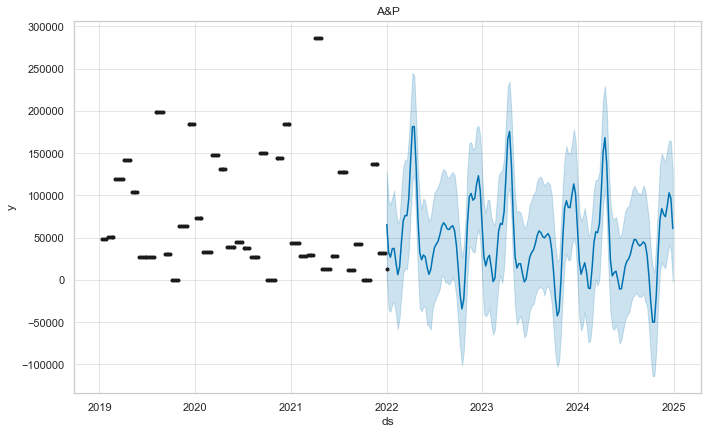

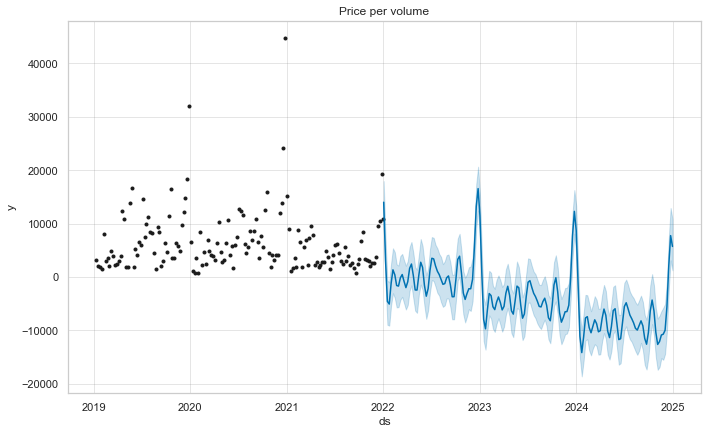

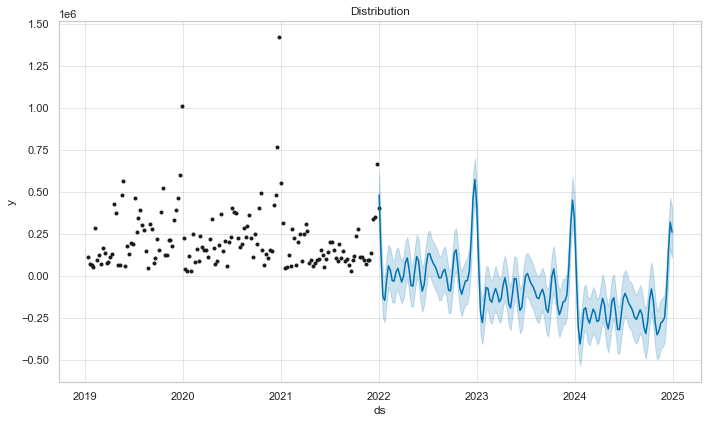

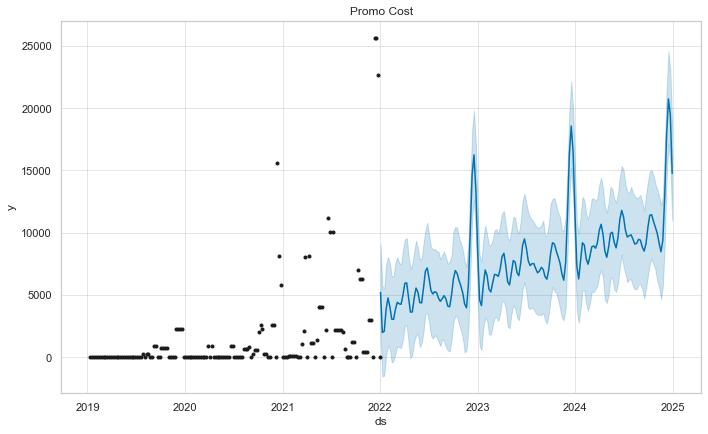

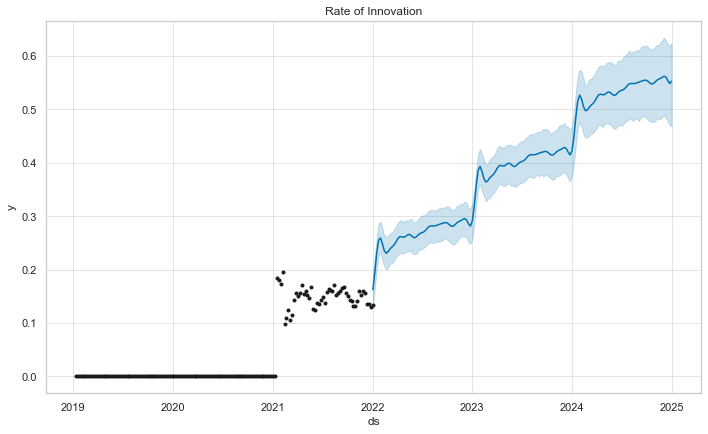

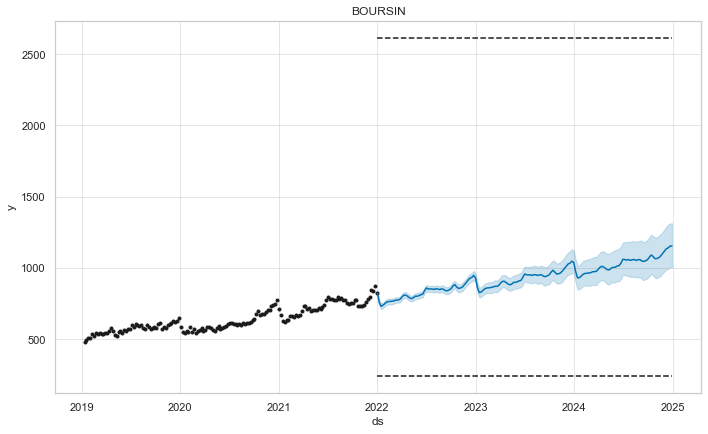

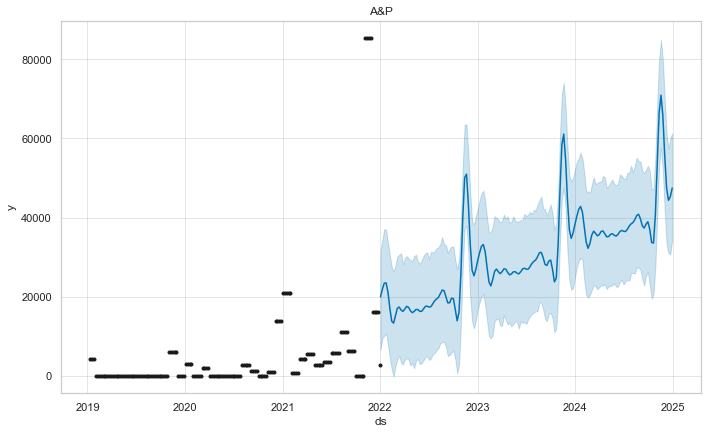

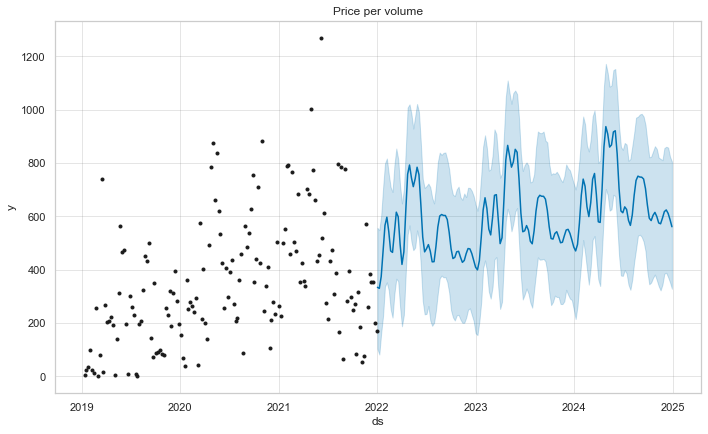

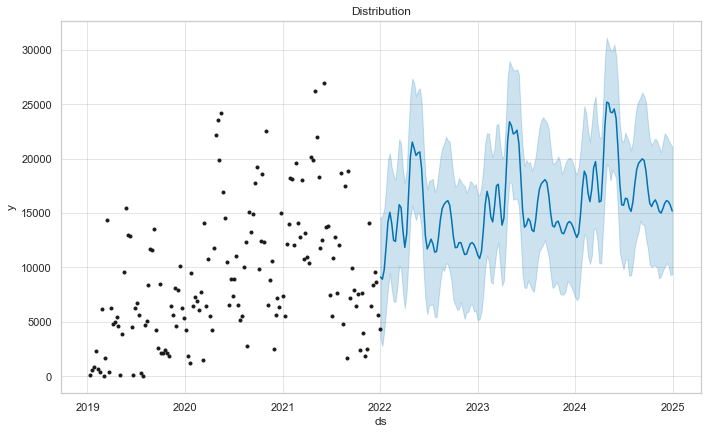

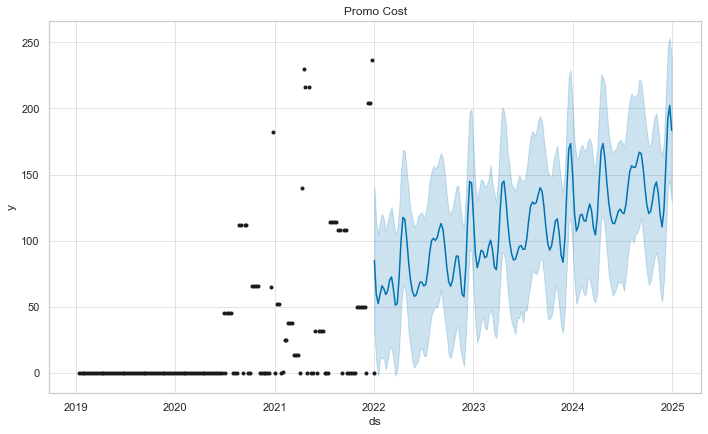

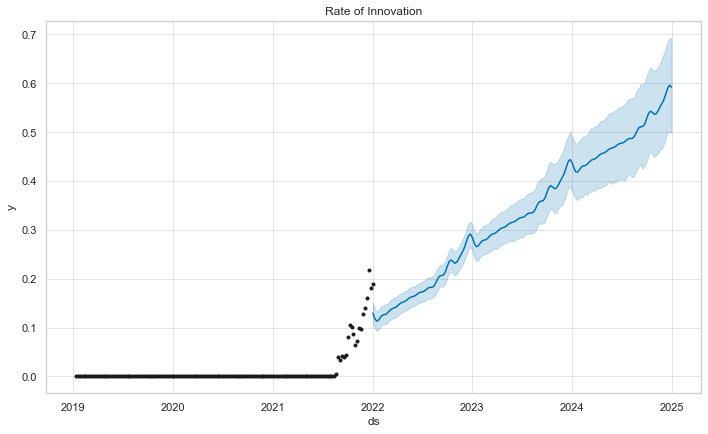

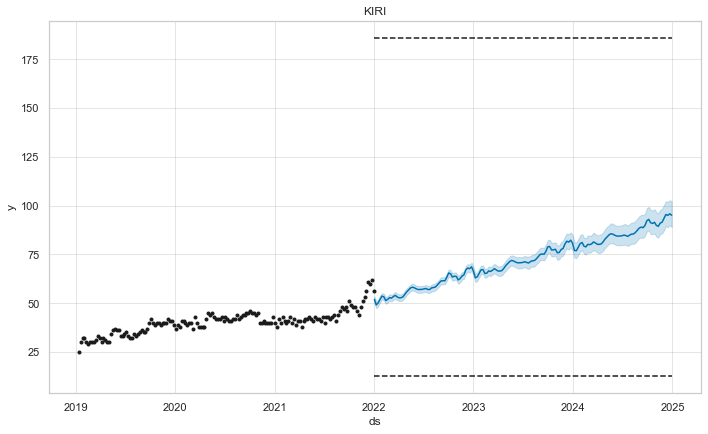

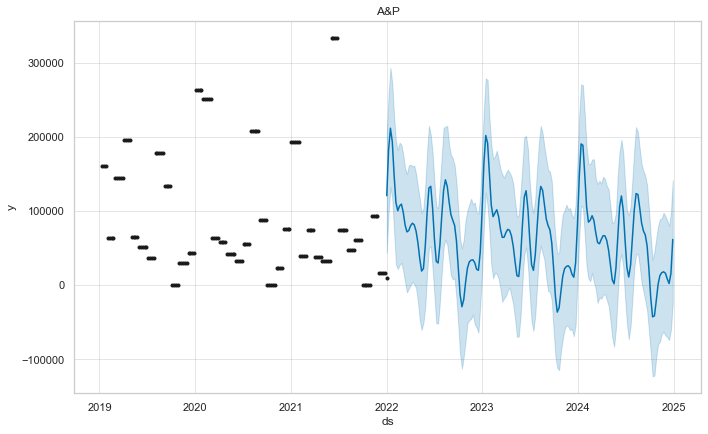

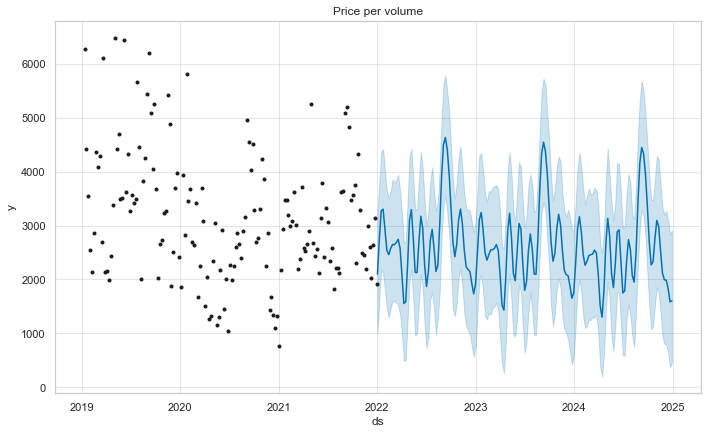

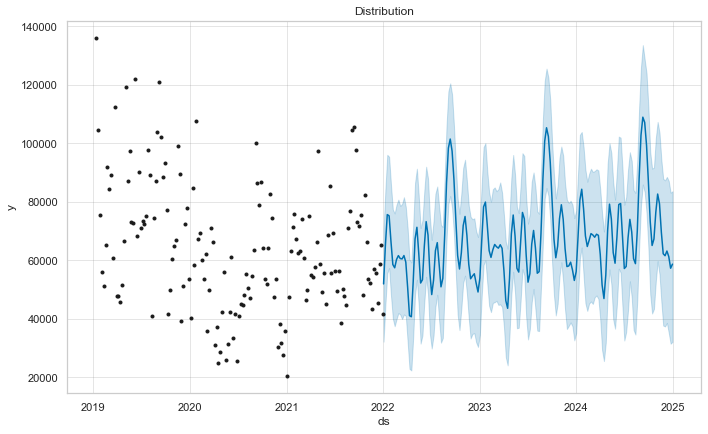

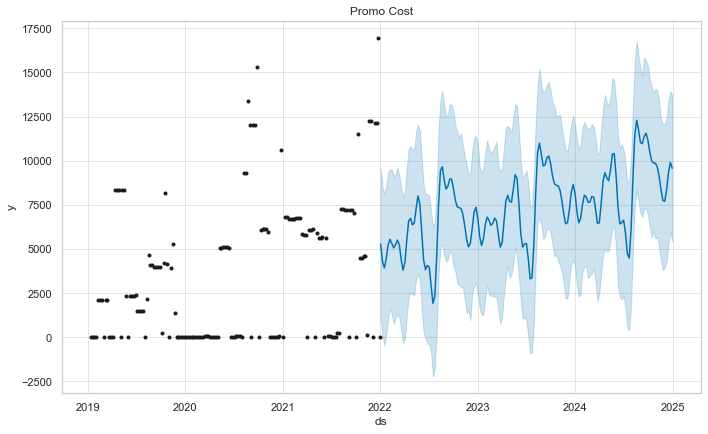

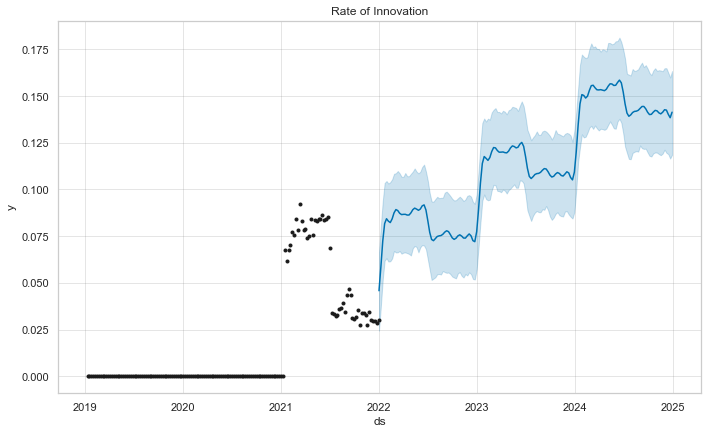

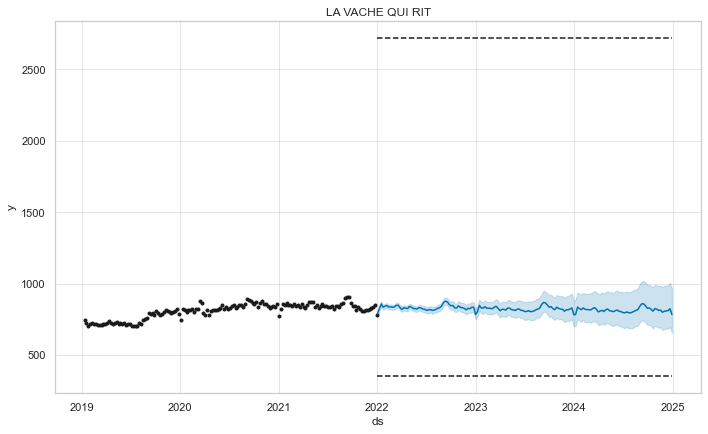

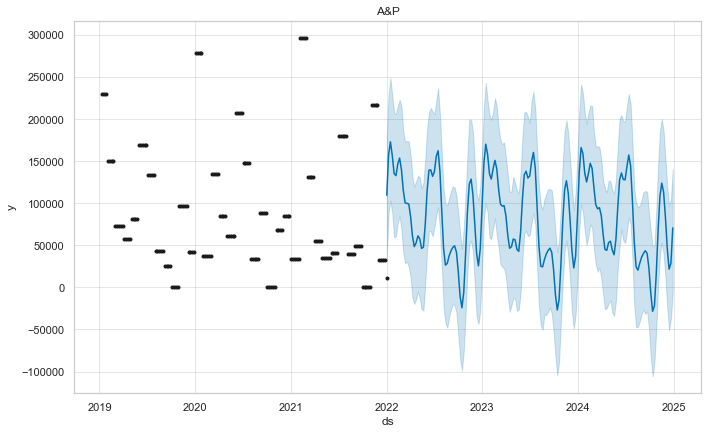

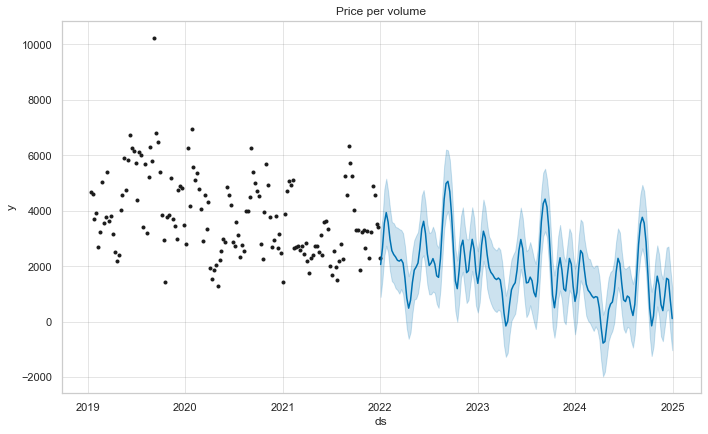

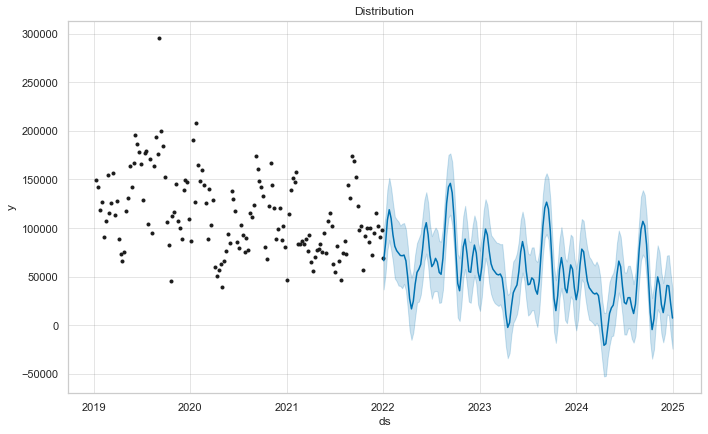

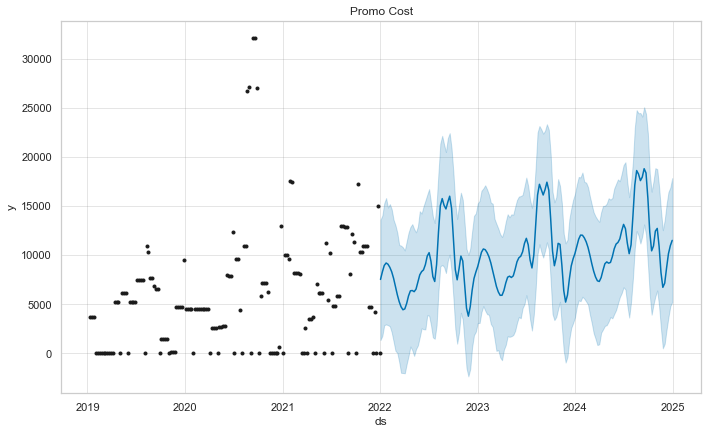

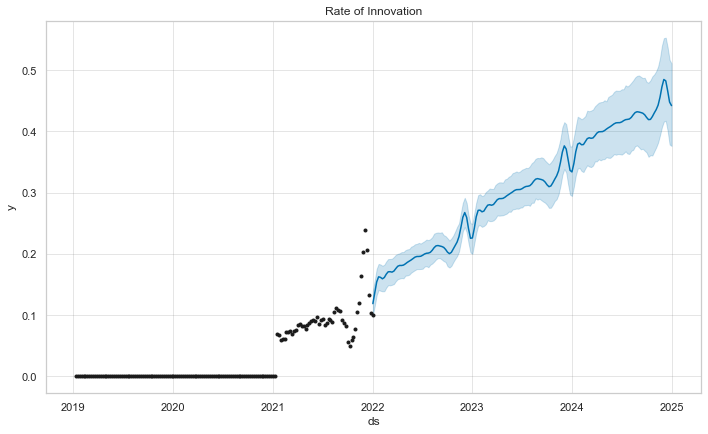

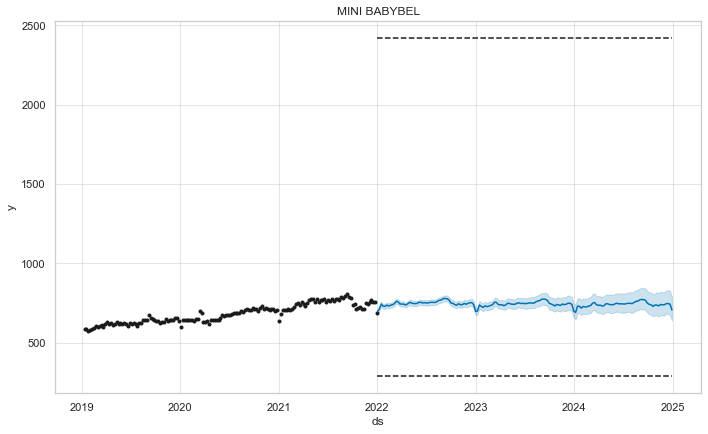

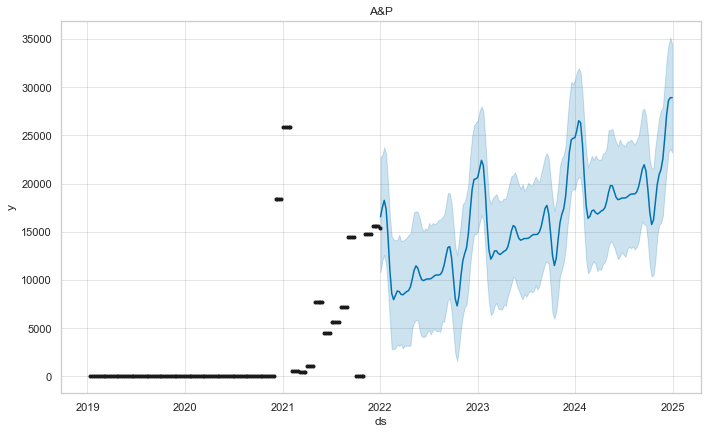

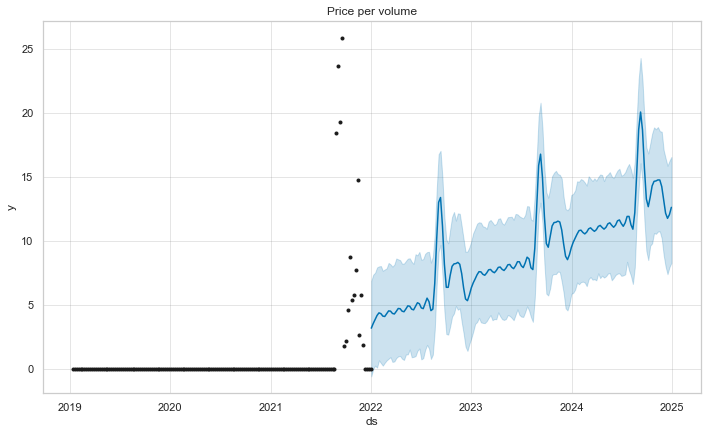

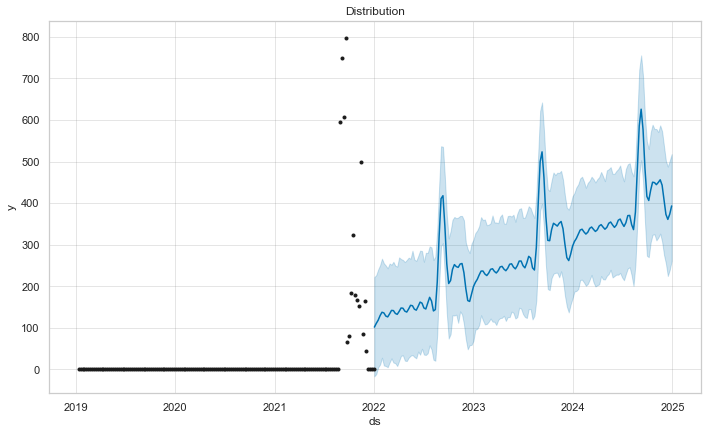

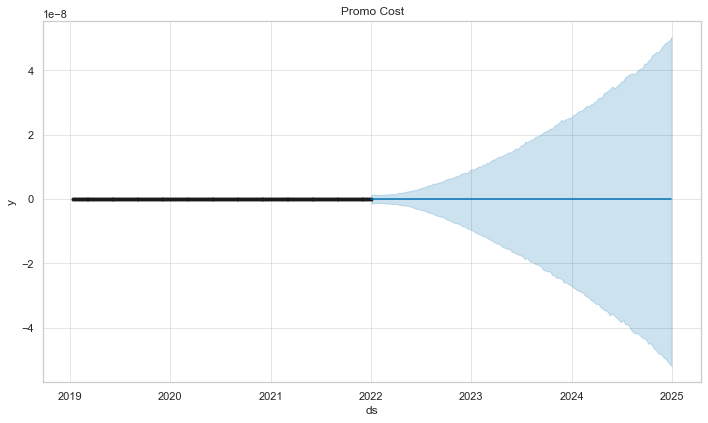

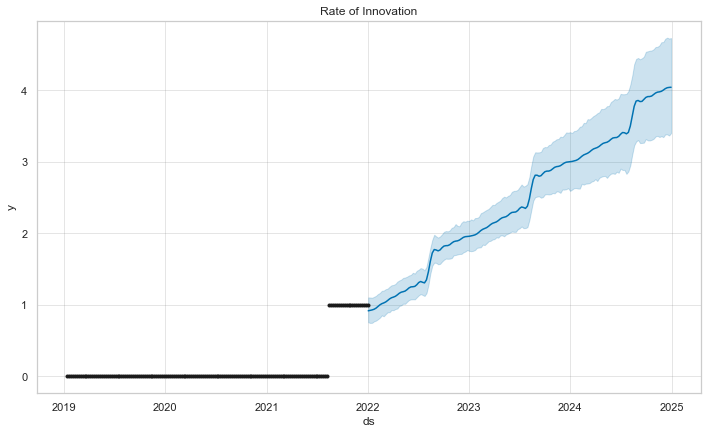

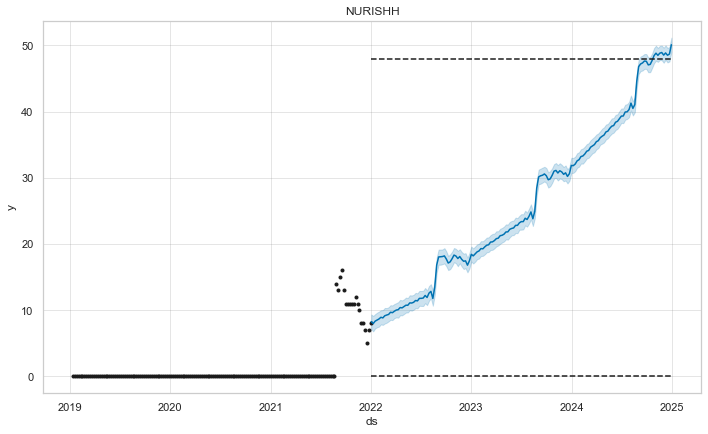

In [130]:
features_name = ['A&P', 'Price per volume', 'Distribution', 'Promo Cost', 'Rate of Innovation']
feats_futures, df_brands_fcst_res = forecasting_brands(df_bel, brands_name[country], features_name, periods=157, freq='W')

In [128]:
df_brands_fcst_res

Date      BOURSIN        KIRI  LA VACHE QUI RIT  MINI BABYBEL  \
0   2019-01-12   477.000000   25.000000        748.000000    589.000000   
1   2019-01-19   496.000000   30.000000        724.000000    587.000000   
2   2019-01-26   508.000000   32.000000        704.000000    576.000000   
3   2019-02-02   506.000000   32.000000        714.000000    583.000000   
4   2019-02-09   536.000000   30.000000        721.000000    588.000000   
..         ...          ...         ...               ...           ...   
308 2024-12-01  1068.907134  124.176215        779.617977    704.382760   
309 2024-12-08  1086.509644  125.991526        783.145541    710.607634   
310 2024-12-15  1091.759356  126.238799        784.046875    710.327617   
311 2024-12-22  1106.781346  126.881191        797.838361    709.562124   
312 2024-12-29  1106.028943  126.308968        756.921510    671.282417   

       NURISHH  
0     0.000000  
1     0.000000  
2     0.000000  
3     0.000000  
4     0.000000  
..         ...  
308  53.052834  
309  53.025199  
310  52.152980  
311  51.853968  
312  52.990017  

[313 rows x 6 columns]

In [131]:
df_brands_fcst_res.fillna(0, inplace=True)
df_brands_fcst_res['Date'] = df_brands_fcst_res.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
df_brands_fcst_res.round(1).to_excel("results/CAN/can_brands_forecasts_with_regressors.xlsx", index=False)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

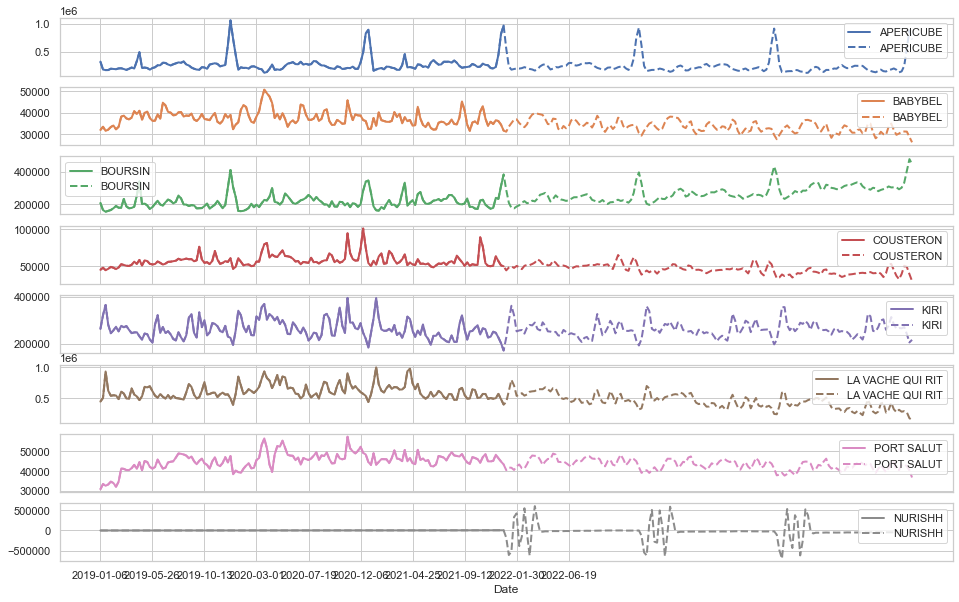

In [13]:
ax = df_brands_fcst_res.set_index("Date").loc['2017-12-31':'2021-12-26'].plot(linewidth=2, subplots=True, figsize=(16, 10))
df_brands_fcst_res.set_index("Date").plot(linewidth=2, linestyle='--', subplots=True, figsize=(16, 10), ax=ax)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

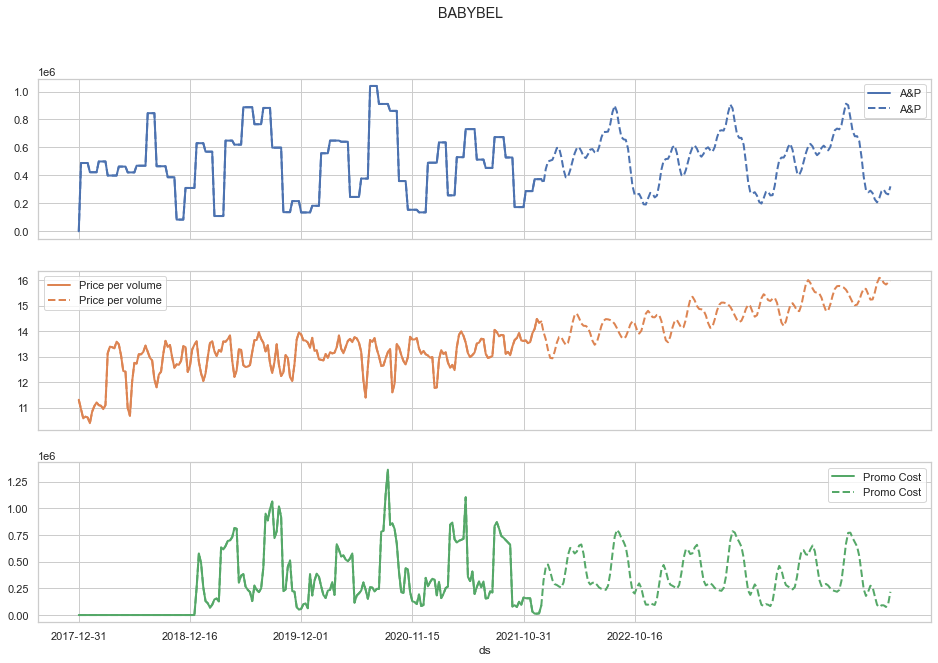

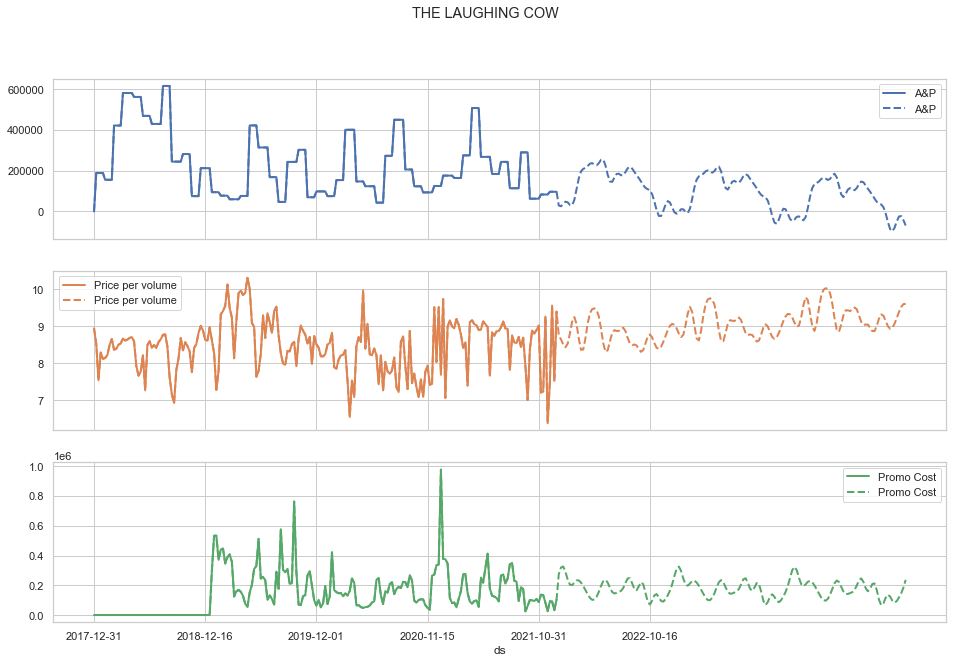

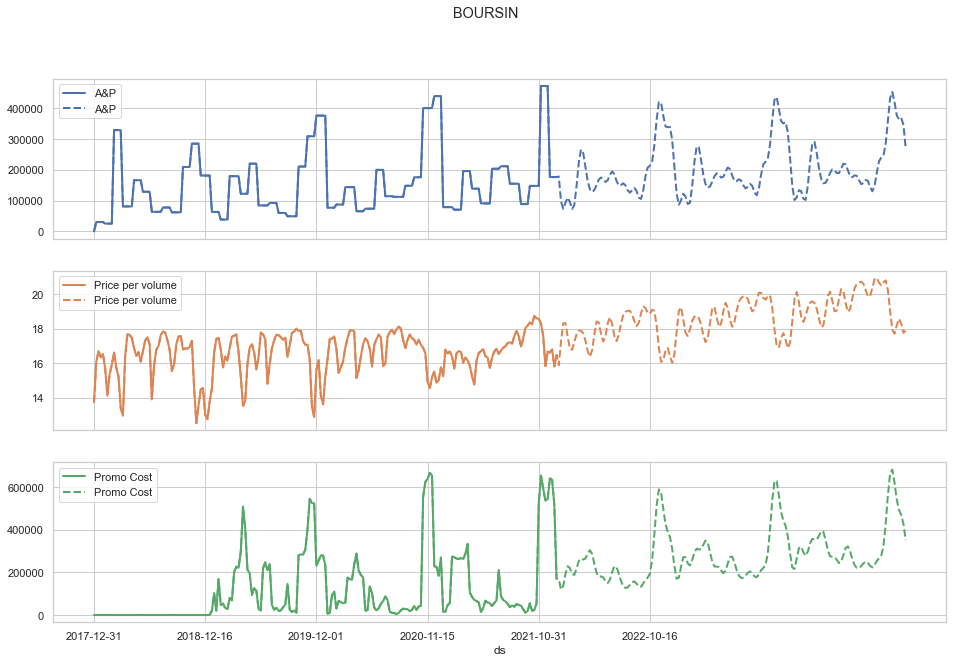

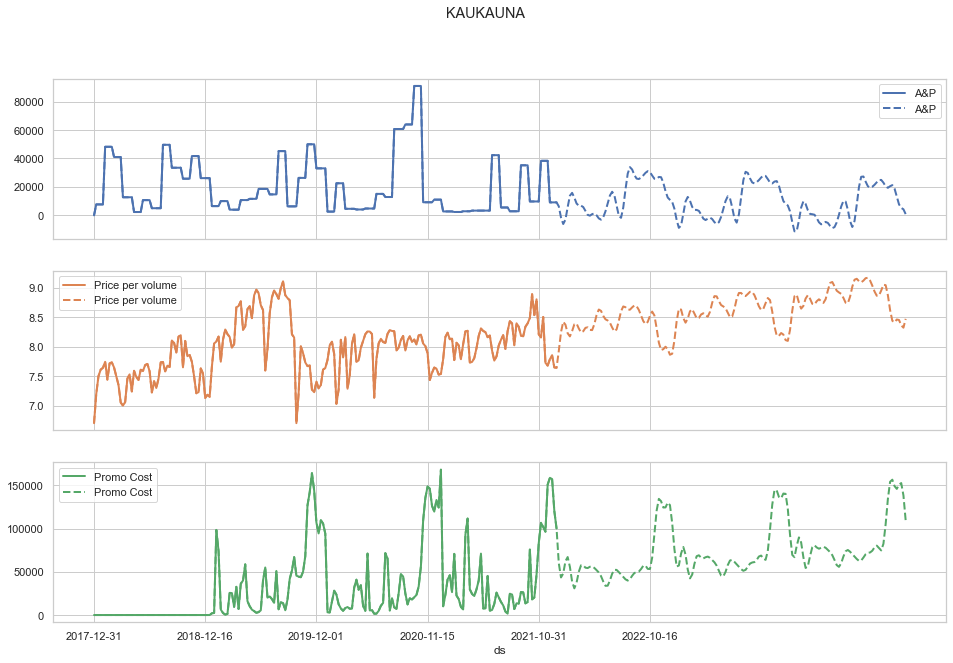

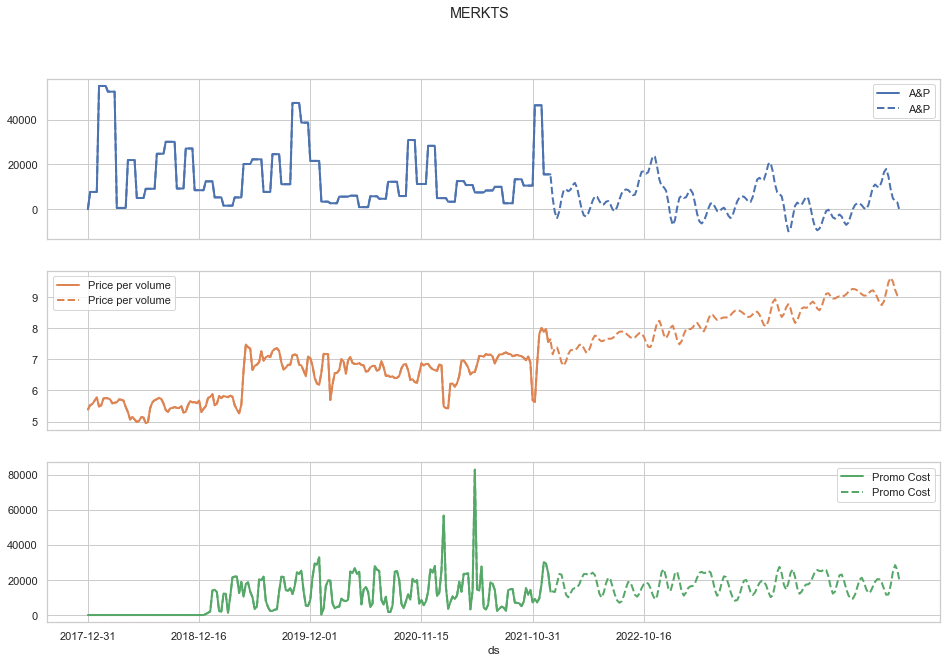

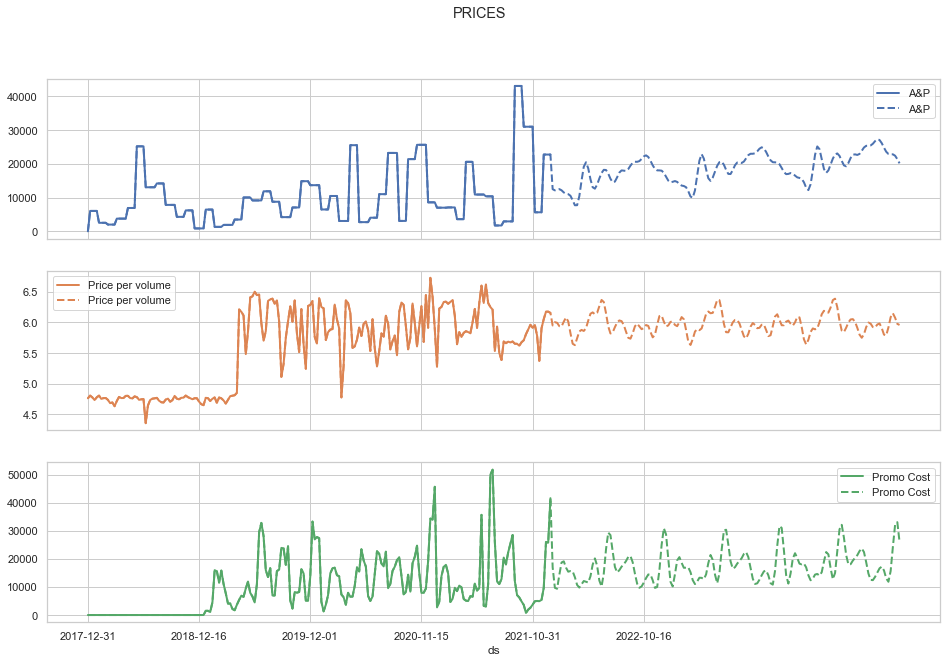

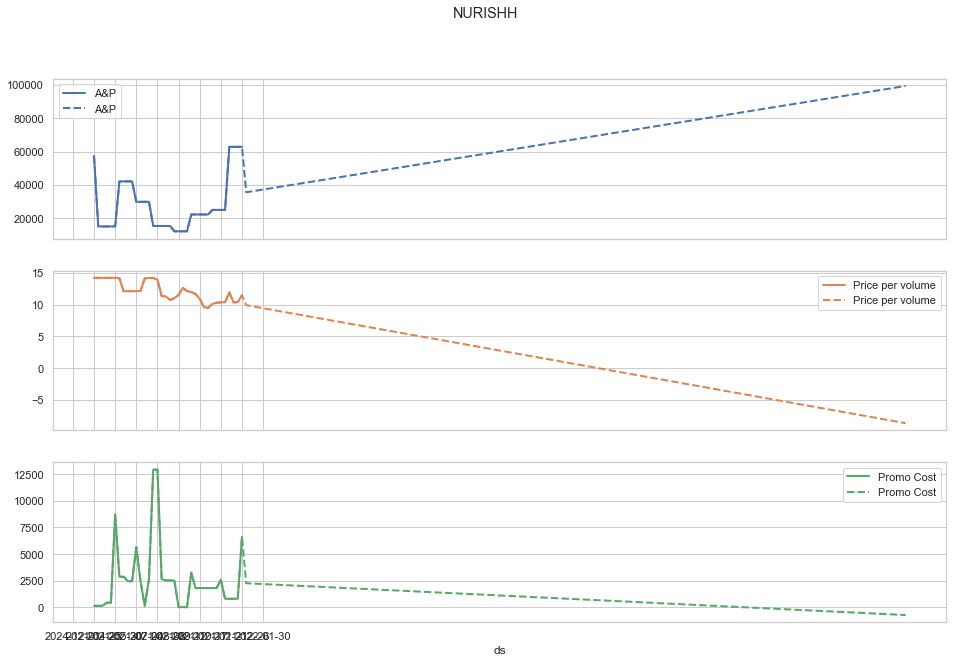

In [123]:
for brand in feats_futures:
    ax = feats_futures[brand].set_index('ds').loc['2017-12-31':'2021-12-26'].plot(subplots=True, figsize=(16, 10), title=brand, linewidth=2);
    feats_futures[brand].set_index('ds').plot(
        subplots=True, figsize=(16, 10), title=brand, 
        linestyle='--', linewidth=2, ax=ax);

### Forecasting Markets

In [52]:
features_markets = list(df.Category.unique()) + ['TOTAL CHEESE']
df_markets = get_df_markets(df)
df_markets.head()

Date   BLOCK  DEHYDRATED  PLANT BASED  PLATTER  SHREDDED  SLICES  \
0  2019-01-12  6717.0        70.0        631.0   6416.0    2910.0  3699.0   
1  2019-01-19  6673.0        72.0        643.0   6568.0    2929.0  3676.0   
2  2019-01-26  6660.0        70.0        625.0   6629.0    2908.0  3637.0   
3  2019-02-02  6848.0        71.0        627.0   6635.0    2953.0  3687.0   
4  2019-02-09  6936.0        78.0        645.0   6811.0    3007.0  3718.0   

   SNACKING  SPECIALTY  SPREADABLE  TOTAL CHEESE  
0    3700.0     4144.0      3038.0       31325.0  
1    3700.0     4167.0      2997.0       31425.0  
2    3634.0     4172.0      3015.0       31350.0  
3    3644.0     4171.0      3037.0       31673.0  
4    3648.0     4224.0      3061.0       32128.0

Features:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -2.89241
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       527.862     0.0021959       147.831       3.624           1      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       528.776   0.000264257       107.444           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       528.785   2.10301e-05       107.965   2.003e-07       0.001      323  LS failed, Hessian reset 
     250       528.806   4.99372e-05       76.6168   7.197e-07       0.001      421  LS failed, Hessian reset 
     299       528.813   3.43891e-05       81.0182       0.968       0.968      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       529.199   4.42219e-06       75.1904      0.8114      0.8114      603   
    Iter      log pro

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -3.08935
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       525.808   0.000245323        73.184      0.6274      0.6274      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       526.772   0.000347781       116.893   1.723e-06       0.001      210  LS failed, Hessian reset 
     184       527.084   3.32747e-05       43.1467   4.943e-07       0.001      320  LS failed, Hessian reset 
     199       527.087    1.7824e-05       53.5816           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       527.089   1.47391e-05       58.0907   2.687e-07       0.001      383  LS failed, Hessian reset 
     240       527.091   3.54797e-06       59.5688   5.757e-08       0.001      464  LS failed, Hessian reset 
     299       527.147    0.00497101        74.254      0.4051   

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -3.67194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       343.175    0.00113316       75.7159      0.2373           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       343.221   4.04069e-09       72.6425         0.2         0.2      190   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -3.03021
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       532.579   0.000869988       400.475           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       532.836   7.22609e-05       170.067   1.729e-06       0.001      185  LS failed, Hessian reset 
     199       534.613   0.000305527       312.948           1           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       534.835   0.000112075       493.843   3.866e-07       0.001      357  LS failed, Hessian reset 
     272       535.156   6.30672e-05       206.074   7.677e-07       0.001      472  LS failed, Hessian reset 
     299        535.19   3.03129e-06       72.9432      0.1494      0.1494      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -20.8356
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       447.274     0.0196383       1054.23       8.839      0.8839      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       456.045    0.00275044       232.632           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       459.733   2.37375e-06       103.563   8.513e-09       0.001      396  LS failed, Hessian reset 
     299       461.416   0.000364654       457.825      0.6651     0.06651      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333        461.79   1.98192e-06       61.4988   8.297e-09       0.001      545  LS failed, Hessian reset 
     380       462.308   5.82978e-06       242.354   6.628e-08       0.001      651  LS failed, Hessian rese

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -11.235
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       387.276    0.00101123       110.042      0.4604      0.4604      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       388.362   1.52834e-05        98.177    1.13e-07       0.001      270  LS failed, Hessian reset 
     199       388.569   0.000695253       148.733      0.6899      0.6899      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       388.672   1.71524e-05       111.069   1.111e-07       0.001      451  LS failed, Hessian reset 
     299       388.952   0.000269482       130.024           1           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       389.751    3.2483e-05       75.1502           1           1      712   
    Iter      log prob

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -2.56028
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       573.267   0.000713756       71.1477       1.419      0.1419      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       573.392   0.000135752       221.909   1.125e-06       0.001      184  LS failed, Hessian reset 
     199       573.712   8.84829e-05       45.1895      0.8011      0.8011      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       573.903   4.95129e-05       68.8703   1.757e-07       0.001      384  LS failed, Hessian reset 
     284       573.993   2.90394e-05        57.807   2.041e-07       0.001      498  LS failed, Hessian reset 
     299       573.998   7.95068e-06       57.1098      0.3057           1      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -38.5708
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.394   0.000379676       1323.26     0.04134           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       411.881   0.000162778       550.449    0.007735           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       421.497      0.015516       2054.11           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       423.368    0.00043672        513.69      0.2782           1      595   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       425.169    0.00045539       92.9141           1           1      737   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -16.1763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       252.893     0.0127192       77.4743           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       254.528   0.000391541        79.809   5.917e-06       0.001      213  LS failed, Hessian reset 
     199       254.555   1.05836e-05       53.7136        3.02           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       254.749    0.00168202       90.7631   2.155e-05       0.001      441  LS failed, Hessian reset 
     299       254.863   4.86968e-05       76.7445           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       254.912   2.36194e-05        58.789      0.7377      0.7377      596   
    Iter      log pro

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -2.81431
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       567.744   0.000117073       191.998      0.1009      0.5018      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       567.998   2.46421e-05       99.8855   1.374e-07       0.001      213  LS failed, Hessian reset 
     170        568.26   2.06715e-05       96.2535   1.708e-07       0.001      315  LS failed, Hessian reset 
     199       568.337     1.339e-05       72.4088       2.063      0.4587      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       568.385   1.95811e-05       89.7029   1.509e-07       0.001      430  LS failed, Hessian reset 
     299       568.488    0.00083672        137.36           1           1      542   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


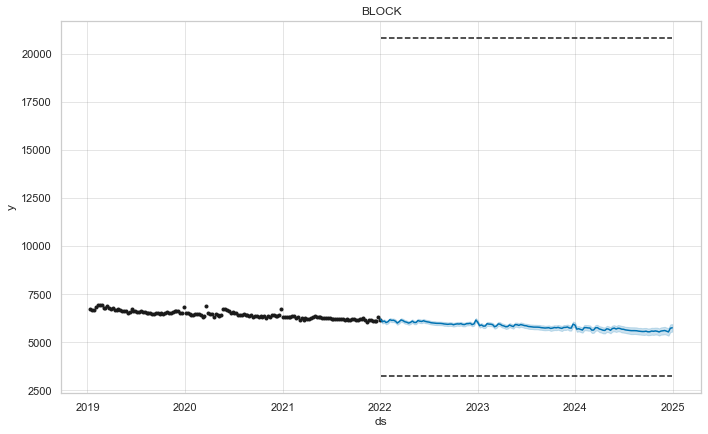

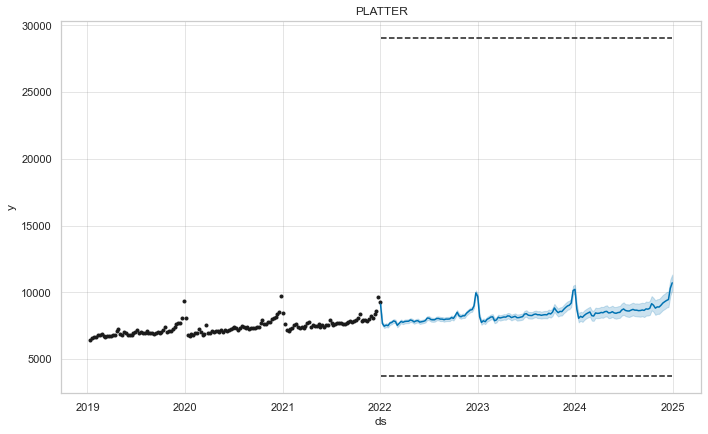

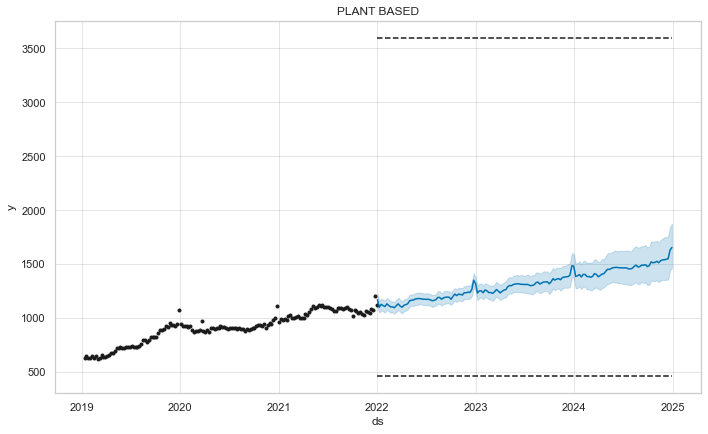

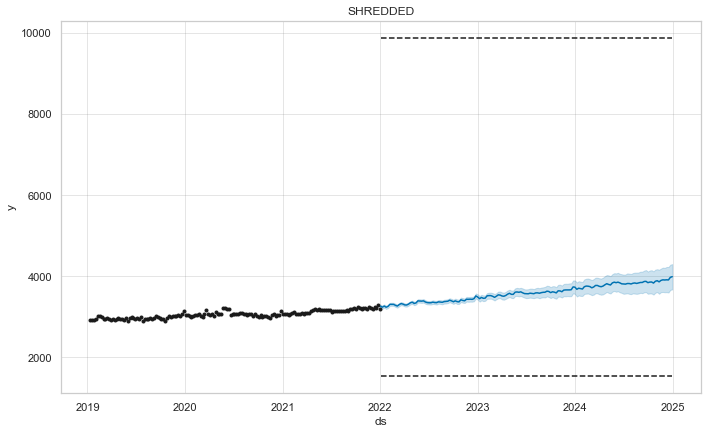

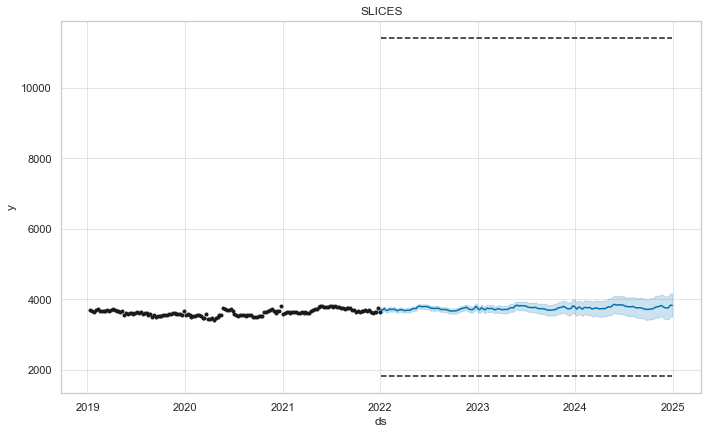

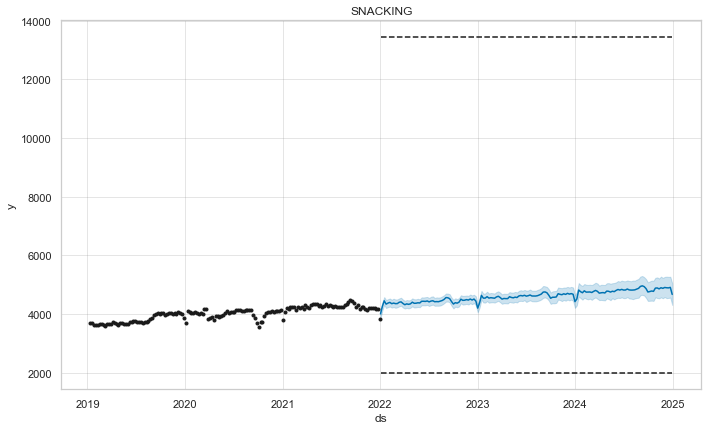

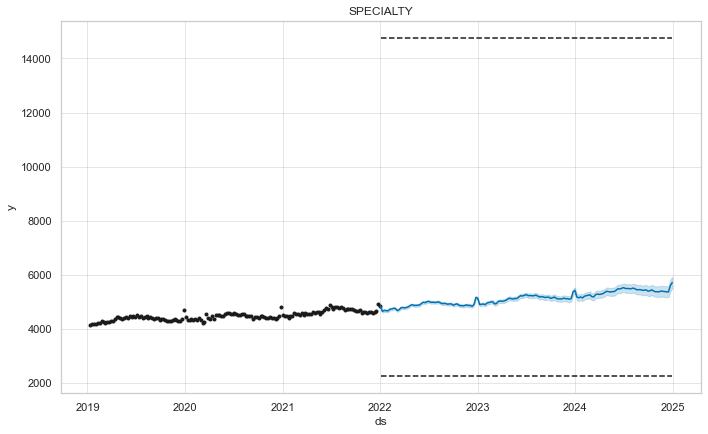

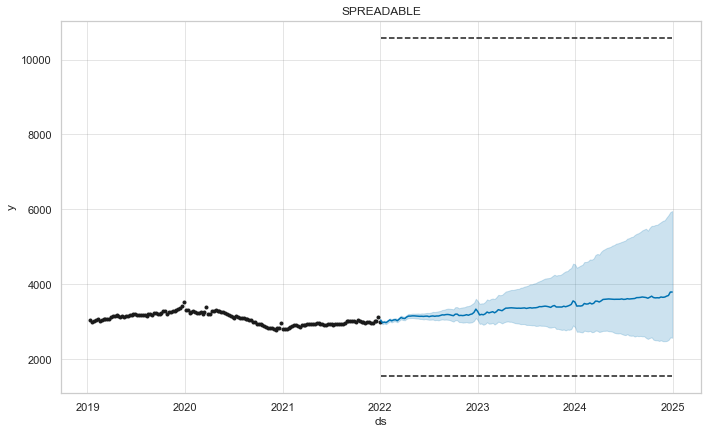

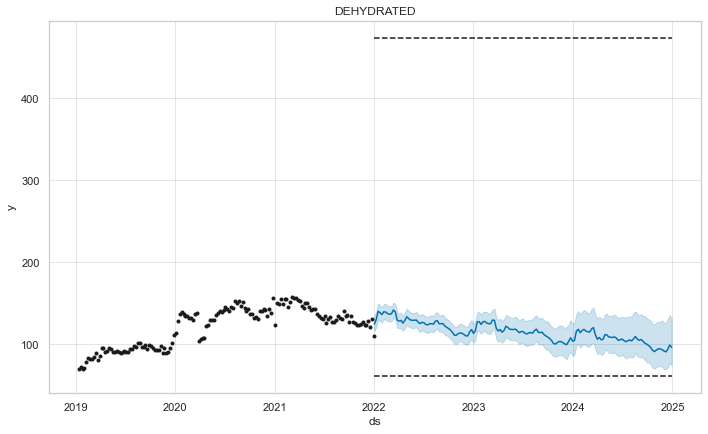

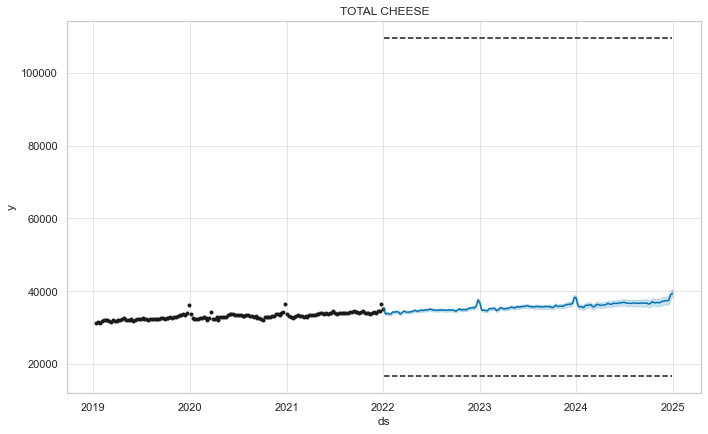

In [53]:
df_markets_fcst_res = forecasting_markets(df_markets, features_markets, periods=157, freq='W')

In [57]:
df_markets_fcst_res.tail()

Date        BLOCK       PLATTER  PLANT BASED     SHREDDED  \
308 2024-12-01  5601.229553   9295.780547  1538.595382  3905.947622   
309 2024-12-08  5568.306143   9388.356316  1543.034700  3910.612876   
310 2024-12-15  5527.107472   9457.818738  1547.139563  3907.074620   
311 2024-12-22  5719.997601  10301.973744  1628.120553  3970.855063   
312 2024-12-29  5743.233785  10709.424039  1652.440714  3987.462580   

          SLICES     SNACKING    SPECIALTY   SPREADABLE  DEHYDRATED  \
308  3758.581167  4910.175785  5379.680701  3655.397680   91.736302   
309  3751.860741  4899.984962  5368.191892  3679.788425   90.700089   
310  3756.968191  4895.747968  5365.070815  3697.362023   93.913862   
311  3830.544685  4913.227555  5592.169917  3789.397943   99.020268   
312  3820.918809  4674.588094  5710.619987  3790.020357   96.170049   

     TOTAL CHEESE  
308  37335.212993  
309  37393.367621  
310  37431.796407  
311  39029.135741  
312  39355.190445

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

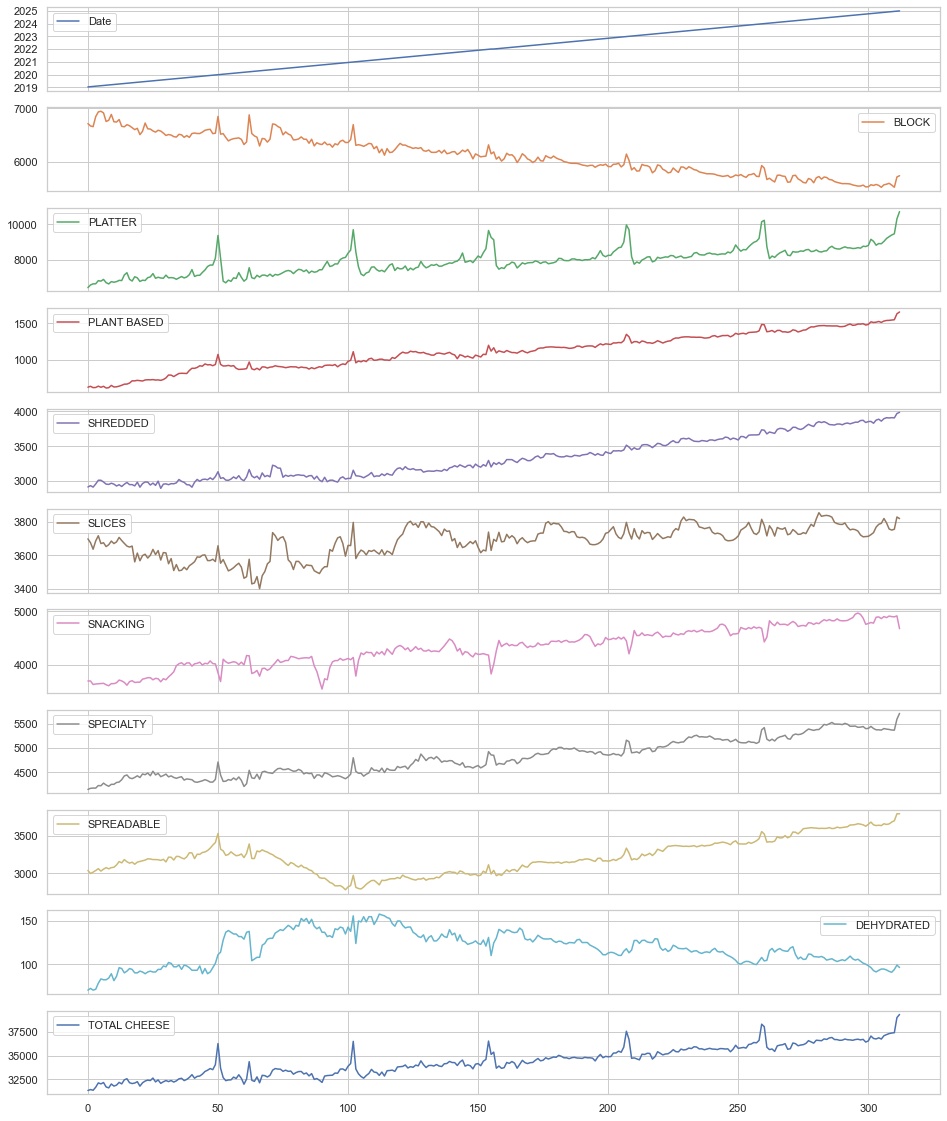

In [56]:
df_markets_fcst_res.plot(subplots=True, figsize=(16, 20))

In [219]:
#df_markets_fcst_res.assign(Year=pd.to_datetime(df_markets_fcst_res.Date).dt.year).groupby('Year').sum().T.to_clipboard()

In [58]:
df_markets_fcst_res['Date'] = df_markets_fcst_res.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
df_markets_fcst_res.round(1).to_excel("./results/CAN/can_usa_markets_forecasts.xlsx", index=False)

In [76]:
df_markets_results = pd.merge(df_gourmet_fcst_res, df_markets_fcst_res, on='Date')
df_markets_results.tail()

Date  GOURMET BLOCK / WEDGE / ROUND  GOURMET CRUMBLED  \
361 2024-12-01                   1.427448e+06     797798.310339   
362 2024-12-08                   1.411002e+06     793358.807713   
363 2024-12-15                   1.567934e+06     844270.306676   
364 2024-12-22                   1.770080e+06     919427.255980   
365 2024-12-29                   1.791477e+06     961966.501930   

     GOURMET FRESH ITALIAN  GOURMET SHREDDED / GRATED  GOURMET SPREADS  \
361           1.276152e+06              332751.871991    640425.132686   
362           1.263219e+06              336799.541064    669862.273462   
363           1.478951e+06              361769.869095    822161.719547   
364           1.726741e+06              388134.488146    979540.584813   
365           1.731182e+06              391959.910474    970586.778792   

     CLASSIC SPREADS  CREAM CHEESE BLOCKS  CREAM CHEESE TUBS  \
361    457319.756492         9.335321e+06       3.959608e+06   
362    466362.910776         8.745482e+06       3.966325e+06   
363    539899.423552         9.612026e+06       4.139455e+06   
364    616995.884305         1.091916e+07       4.324110e+06   
365    606311.259774         1.061566e+07       4.324926e+06   

     ENTERTAINING TRAYS  ...  EVERYDAY SHREDDED & GRATED       GOURMET  \
361        1.645872e+06  ...                2.821070e+07  4.607664e+06   
362        1.732246e+06  ...                2.778234e+07  4.608752e+06   
363        2.167063e+06  ...                2.971123e+07  5.210300e+06   
364        2.663926e+06  ...                3.226533e+07  5.918810e+06   
365        2.744565e+06  ...                3.280496e+07  5.981270e+06   

           PIMENTO  RICOTTA AND FARMERS  SINGLE SERVE        SLICES  \
361  336115.187332         2.122262e+06    609.315736  1.422315e+07   
362  351566.226454         2.474562e+06    604.470550  1.419426e+07   
363  379563.625557         3.285347e+06    440.605670  1.436223e+07   
364  391749.670678         3.917995e+06     96.886920  1.462187e+07   
365  371538.883583         3.784911e+06   -102.376548  1.482039e+07   

            SNACK  SNACKING COMBOS    PLANT BASED  TOTAL CHEESE  
361  7.314728e+06     4.581783e+06  479116.276372  9.314850e+07  
362  7.373626e+06     4.727702e+06  474500.465954  9.188077e+07  
363  7.360306e+06     4.614616e+06  487486.689125  9.793698e+07  
364  7.283961e+06     4.326532e+06  507043.058425  1.059140e+08  
365  7.307407e+06     4.214736e+06  516293.924305  1.068928e+08  

[5 rows x 21 columns]

In [78]:
df_markets_results = df_markets_results[['Date', 'GOURMET BLOCK / WEDGE / ROUND', 'GOURMET CRUMBLED',
       'GOURMET FRESH ITALIAN', 'GOURMET SHREDDED / GRATED', 'GOURMET SPREADS', 'GOURMET',
       'CLASSIC SPREADS', 'CREAM CHEESE BLOCKS', 'CREAM CHEESE TUBS',
       'ENTERTAINING TRAYS', 'EVERYDAY BLOCKS', 'EVERYDAY SHREDDED & GRATED',
       'PIMENTO', 'RICOTTA AND FARMERS', 'SINGLE SERVE', 'SLICES',
       'SNACK', 'SNACKING COMBOS', 'PLANT BASED', 'TOTAL CHEESE']]

In [79]:
df_markets_results['Date'] = df_markets_results.Date.apply(lambda x: x.strftime('%Y-%m-%d'))

In [80]:
df_markets_results.to_excel("./results/usa_markets_forecasts.xlsx", index=False)

### Growth Drivers Past

- Distribution per : mean
- Price per volume per category : mean
- Competition price per category : mean
- Competition sales per category : sum


In [132]:
def growth_drivers(df_bel, df_markets, df_competition_brands, brands_name, brands_markets, controllable_features=False):
    dict_res = {'xgb_feature_importance': {}, 'permutation_importance': {}}
    competition_feats_cat = ['Competition price', 'Competition sales']
    compet_feats = []
    for brand in tqdm(brands_name, ascii=True, desc='Brands'):
        # Competition features
        feats_cat = [feat+'_'+cat for cat in brands_markets[brand] 
                     for feat in competition_feats_cat]
        df_tmp = df_bel[df_bel.Brand == brand]
        if not controllable_features:
            df_tmp = pd.merge(df_tmp, df_competition_brands[['Date'] + feats_cat], on='Date')
            df_tmp = pd.merge(df_tmp, df_markets[['Date'] + brands_markets[brand]], on='Date')
        
        if len(df_tmp) == 0:
            continue
        
        # Add competition features if df_tmp is not empty (eg: NURISHH for 2019, 2020, etc...) 
        compet_feats += feats_cat
        
        for key in dict_res:
            dict_res[key][brand] = {}
        
        df_tmp_X = df_tmp.drop(['Date', 'Brand', 'Sales in volume'], axis=1)
        X = df_tmp_X.values
        y = df_tmp['Sales in volume']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
        xgb_model = XGBRegressor()
        xgb_model.fit(X_train, y_train)

        # XGB Feature importance
        feature_importances = xgb_model.feature_importances_
        sorted_idx_feat_imp = feature_importances.argsort()
        perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=25)
        sorted_idx_perm_imp = perm_importance.importances_mean.argsort()
        for idx_fi, idx_pi in zip(sorted_idx_feat_imp, sorted_idx_perm_imp):
            dict_res['xgb_feature_importance'][brand][df_tmp_X.columns[idx_fi]] = feature_importances[idx_fi] * 100
            dict_res['permutation_importance'][brand][df_tmp_X.columns[idx_pi]] = perm_importance['importances_mean'][idx_pi] * 100

    # Set compet feats, cause many brands are in the same markets. 
    # np.delete, in order to remove 'Sales in volume', and [2:], to remove Date and Brand
    if controllable_features:
        ordered_drivers = list(df_bel.columns[2:-1])
    else:
        bel_markets = list(set([elem for brand in dict_res['xgb_feature_importance'] for elem in brands_markets[brand]]))
        ordered_drivers = bel_markets + list(set(compet_feats)) + list(df_bel.columns[2:-1])
        
    print(ordered_drivers)
    for dict_imp in dict_res:
        dict_res[dict_imp] = pd.DataFrame(dict_res[dict_imp]).loc[ordered_drivers]
        
    return dict_res

def compute_growth_drivers_past(df, df_bel, brands_name, features, years=[2018, 2019, 2020, 2021], controllable_features=False):
    """
    """

    brands_markets = {brand: df[df.Brand == brand].Category.unique().tolist() for brand in brands_name}
    # Get markets dataframe
    df_markets = get_df_markets(df)
    # Computing competition price and sales for bel brands
    df_competition_brands = get_df_competition_brands(df, brands_name, features)
    df_competition_brands = df_competition_brands.groupby(['Date', 'Category']).agg(
        {'Price per volume': np.mean, 
         'Sales in volume':  np.sum}).unstack().rename(
        columns={'Price per volume': 'Competition price', 'Sales in volume': 'Competition sales'})
    df_competition_brands.columns = ['_'.join(elem) for elem in df_competition_brands.columns]
    df_competition_brands = df_competition_brands.reset_index()
    dict_res = {year:{} for year in years}
    
    for year in tqdm(years, ascii=True, desc='Years'):
        df_bel_year = df_bel[df_bel.Date.astype('datetime64[ns]').dt.year == year]
        df_compet_year = df_competition_brands[df_competition_brands.Date.astype('datetime64[ns]').dt.year == year]
        df_markets_year = df_markets[df_markets.Date.astype('datetime64[ns]').dt.year == year]
        
        dict_res[year] = growth_drivers(df_bel_year, df_markets_year, 
                                        df_compet_year, brands_name, brands_markets, 
                                        controllable_features=controllable_features)
        
    dict_res['all'] = growth_drivers(df_bel, df_markets, df_competition_brands, 
                                     brands_name, brands_markets, 
                                     controllable_features=controllable_features)
    
    return dict_res

In [136]:
df_bel.head()

Date             Brand  Price per volume  Sales in volume  \
0  2019-01-12           BOURSIN       3153.150000              477   
1  2019-01-12              KIRI          4.100000               25   
2  2019-01-12  LA VACHE QUI RIT       6282.500000              748   
3  2019-01-12      MINI BABYBEL       4692.633333              589   
4  2019-01-12           NURISHH          0.000000                0   

   Sales in value   Distribution            A&P  Rate of Innovation  \
0          493926  111037.500000   48910.862475                 0.0   
1           17202     125.000000    4308.950000                 0.0   
2          733335  136112.000000  160014.455025                 0.0   
3          888460  149572.333333  229418.949975                 0.0   
4               0       0.000000       0.000000                 0.0   

   Promo Cost  Trends  
0         0.0      39  
1         0.0       2  
2         0.0       0  
3      3716.4       0  
4         0.0       0

In [139]:
bel_features = ['Date', 'Brand', 'A&P', 'Price per volume', 'Rate of Innovation', 'Promo Cost', 'Distribution', 'Trends', 'Sales in volume']
# bel_features = ['Date', 'Brand', 'A&P', 'Price per volume', 'Distribution', 'Sales in volume']
dict_res = compute_growth_drivers_past(
    df, df_bel[bel_features], brands_name[country], features, 
    years=[2019, 2020, 2021], controllable_features=False)

Years:   0%|          | 0/3 [00:00<?, ?it/s]

Brands:   0%|          | 0/5 [00:00<?, ?it/s]

['SPREADABLE', 'SNACKING', 'PLATTER', 'PLANT BASED', 'SPECIALTY', 'Competition sales_SPECIALTY', 'Competition sales_PLANT BASED', 'Competition price_SNACKING', 'Competition sales_SPREADABLE', 'Competition sales_PLATTER', 'Competition price_SPREADABLE', 'Competition price_SPECIALTY', 'Competition price_PLANT BASED', 'Competition price_PLATTER', 'Competition sales_SNACKING', 'A&P', 'Price per volume', 'Rate of Innovation', 'Promo Cost', 'Distribution', 'Trends']


Brands:   0%|          | 0/5 [00:00<?, ?it/s]

['SPREADABLE', 'SNACKING', 'PLATTER', 'PLANT BASED', 'SPECIALTY', 'Competition sales_SPECIALTY', 'Competition sales_PLANT BASED', 'Competition price_SNACKING', 'Competition sales_SPREADABLE', 'Competition sales_PLATTER', 'Competition price_SPREADABLE', 'Competition price_SPECIALTY', 'Competition price_PLANT BASED', 'Competition price_PLATTER', 'Competition sales_SNACKING', 'A&P', 'Price per volume', 'Rate of Innovation', 'Promo Cost', 'Distribution', 'Trends']


Brands:   0%|          | 0/5 [00:00<?, ?it/s]

['SPREADABLE', 'SNACKING', 'PLATTER', 'PLANT BASED', 'SPECIALTY', 'Competition sales_SPECIALTY', 'Competition sales_PLANT BASED', 'Competition price_SNACKING', 'Competition sales_SPREADABLE', 'Competition sales_PLATTER', 'Competition price_SPREADABLE', 'Competition price_SPECIALTY', 'Competition price_PLANT BASED', 'Competition price_PLATTER', 'Competition sales_SNACKING', 'A&P', 'Price per volume', 'Rate of Innovation', 'Promo Cost', 'Distribution', 'Trends']


Brands:   0%|          | 0/5 [00:00<?, ?it/s]

['SPREADABLE', 'SNACKING', 'PLATTER', 'PLANT BASED', 'SPECIALTY', 'Competition sales_SPECIALTY', 'Competition sales_PLANT BASED', 'Competition price_SNACKING', 'Competition sales_SPREADABLE', 'Competition sales_PLATTER', 'Competition price_SPREADABLE', 'Competition price_SPECIALTY', 'Competition price_PLANT BASED', 'Competition price_PLATTER', 'Competition sales_SNACKING', 'A&P', 'Price per volume', 'Rate of Innovation', 'Promo Cost', 'Distribution', 'Trends']


In [190]:
df.columns

Index(['Product', 'Category', 'Sub Category', 'Brand', 'Channel', 'Date',
       'Sales in value', 'Sales value with promo', 'Sales in volume',
       'Sales volume with promo', 'Distribution', 'Price per volume',
       'Price with promo'],
      dtype='object')

In [192]:
df_bel.dtypes

Date                   object
Brand                  object
Price per volume      float64
Sales in volume         int64
Sales in value          int64
Distribution          float64
A&P                   float64
Rate of Innovation    float64
Promo Cost            float64
Trends                  int64
dtype: object

In [140]:
for year in dict_res:
    pd.DataFrame(dict_res[year]['xgb_feature_importance']).round(1).to_excel("results/CAN/can_growth_drivers_past_{}.xlsx".format(year))

### Rescale Growth Drivers with Only Controllable features

In [155]:
for year in dict_res:
    df_tmp = pd.DataFrame(dict_res[year]['xgb_feature_importance']).loc[['A&P', 'Price per volume', 'Rate of Innovation', 'Promo Cost', 'Distribution']]
    df_tmp.apply(lambda x: (x * 100) / x.sum()).round(1).to_excel("results/CAN/can_growth_drivers_past_{}_controllable_features.xlsx".format(year))

### Growth Drivers Future

In [33]:
df_futures = pd.DataFrame()
for brand in feats_futures:
    feats_futures[brand]['ds'] = feats_futures[brand]['ds'].apply(lambda x: x.strftime("%Y-%m-%d"))
    df_tmp = pd.merge(feats_futures[brand].rename(columns={'ds':'Date'}), 
                     df_brands_fcst_res[['Date', brand]], on='Date').rename(
        columns={brand: 'Sales in volume'})
    df_tmp['Brand'] = brand
    df_futures = pd.concat([df_futures, df_tmp])

In [34]:
df_futures

Date           A&P  Price per volume  Distribution           cap  \
0    2019-01-06  29844.037500         13.433249    992.622737  1.466558e+06   
1    2019-01-13  29844.037500         13.790680    948.364338  1.466558e+06   
2    2019-01-20  29844.037500         13.803891    931.931438  1.466558e+06   
3    2019-01-27  29844.037500         13.756032    926.602265  1.466558e+06   
4    2019-02-03  32382.817500         13.206180    941.857713  1.466558e+06   
..          ...           ...               ...           ...           ...   
191  2024-12-01  45184.622896         10.115975     80.080013  1.067834e+04   
192  2024-12-08  45312.271238         10.083302     80.382619  1.067834e+04   
193  2024-12-15  45439.919581         10.050629     80.685225  1.067834e+04   
194  2024-12-22  45567.567923         10.017955     80.987832  1.067834e+04   
195  2024-12-29  45695.216266          9.985282     81.290438  1.067834e+04   

            floor  Sales in volume      Brand  
0    25539.226118    146366.553337  APERICUBE  
1    25539.226118     77416.328112  APERICUBE  
2    25539.226118     74628.923692  APERICUBE  
3    25539.226118     73392.476410  APERICUBE  
4    25539.226118     83403.581422  APERICUBE  
..            ...              ...        ...  
191      0.780000     26399.733712    NURISHH  
192      0.780000     26774.610103    NURISHH  
193      0.780000     26250.244271    NURISHH  
194      0.780000     27804.586789    NURISHH  
195      0.780000     18618.554638    NURISHH  

[2387 rows x 8 columns]

In [36]:
dict_res_future = compute_growth_drivers_past(
    df_hmsm, df_futures[df_futures.Date > df_bel_hmsm.Date.iloc[-1]][bel_features], brands_name[country], features, 
    years=[2022, 2023, 2024], controllable_features=True)

Years:   0%|          | 0/3 [00:00<?, ?it/s]

Brands:   0%|          | 0/8 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Distribution']


Brands:   0%|          | 0/8 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Distribution']


Brands:   0%|          | 0/8 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Distribution']


Brands:   0%|          | 0/8 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Distribution']


In [37]:
for year in dict_res_future:
    pd.DataFrame(dict_res_future[year]['xgb_feature_importance']).round(1).to_excel("results/FR/HMSM/fr_hmsm_growth_drivers_future_{}_controllable_features.xlsx".format(year))